In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [82]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

# Finding Realted Countries

In [0]:
#this function returns a country's time series from the day first case was reported
def getTimeSeriesFromDayofFirstRegisteredCase(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)  #getting the data from the day of first case reported

#this function returns a country's time series from the day first case was reported
def getTimeSeriesCountry(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return series

def getTimeSeriesTill10thMay(country,dataset):
  dataset1 = dataset.loc[:,:'5/10/20']
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)

def getCroppedSeriesLength(country,dataset):
  return len(getTimeSeriesFromDayofFirstRegisteredCase(country,dataset))


# takes a dictionary with 6 key value pairs, the value must be the list representing the trend. First key value pair is comapred against rest 5
def printTrends(countriesTrends,title):
  countries = list(countriesTrends.keys())
  print(countries[0],len(countriesTrends[countries[0]]))
  fig,axs = plt.subplots(1,5,figsize=(40,8))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  index = 1
  mainTrendLength = len(countriesTrends[countries[0]])
  for i in range (5):
      print(countries[index],len(countriesTrends[countries[index]]))
      data = countriesTrends[countries[index]]
      axs[i].plot(data[:mainTrendLength], label = countries[index])
      axs[i].plot(countriesTrends[countries[0]], label = countries[0])
      axs[i].set_title(countries[index])
      axs[i].legend(loc='upper left')
      index+=1
  for ax in axs.flat:
      ax.set(xlabel='Day', ylabel='Confirmed Cases')

  fig,axs = plt.subplots(figsize=(10,10))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  axs.plot(countriesTrends[countries[0]], label = countries[0])
  index = 1
  for i in range (5):
      data = countriesTrends[countries[index]]
      axs.plot(data[:mainTrendLength], label = countries[index])
      axs.set_title(countries[index])
      index+=1
  axs.legend(loc='upper left')
  axs.set(xlabel='Day', ylabel='Confirmed Cases')

def getTop5(values,rev = True):
  top5Countries = list(values.keys())[1:6]
  result = {}
  for x in top5Countries:
    if (x in values.keys()):
      result[x] = values[x]
  result = {k: v for k, v in sorted(result.items(),reverse = rev, key=lambda item: item[1])}
  return result


def getSeries(type,country,dataset):
  if type == 0:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)
  elif type == 1:
    return getTimeSeriesCountry(country,dataset)
  elif type == 2:
    return getTimeSeriesTill10thMay(country,dataset)
  else:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)


In [0]:
#0 = getTimeSeriesFromDayofFirstRegisteredCase
#1 = getTimeSeriesCountry
#2 = getTimeSeriesTill10thMay
TYPE1 = 2
TYPE2 = 2
#127 since the beginning of record and until 27th May
#92 since first case and until 27th May
#75 since first case until 10th May
PAKISTAN_SERIES_LENGTH = 75

## Comparing Countries w.r.t Correlation

In [562]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE1,"Pakistan",dataset)
correlations = {}
for country in countries:
  countrySeries = getSeries(TYPE1,country,dataset)
  length = len(countrySeries)
  # if (TYPE1 == 1):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 25000 cases or with length less than pakistan
    continue
  data = np.array([[pakistanSeries[idx] for idx in range(rng)], [countrySeries[idx] for idx in range(rng)]])
  arr = np.corrcoef(data) #finind correlations
  nan_array = np.isnan(arr)
  if (not nan_array[0][1]):
    correlations[country] = list(arr)[0][1]
correlations = {k: v for k, v in sorted(correlations.items(),reverse = True, key=lambda item: item[1])} #sorting countires by correlation
print(correlations)

{'Pakistan': 1.0, 'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697, 'Germany': 0.9783518038592292, 'France': 0.9661904281908088, 'United Kingdom': 0.9658478959836521, 'Canada': 0.9396329683421342, 'India': 0.9193087772122968, 'Russia': 0.902233470011448, 'US': 0.900122479138501, 'Iran': 0.8995009815697568, 'Switzerland': 0.7908363792550077, 'China': 0.547702477922894}


In [563]:
# getting only top 5 countries
relationValues = getTop5(correlations,True)
print(relationValues)

{'Brazil': 0.9973183087147555, 'Sweden': 0.9918830915864273, 'Belgium': 0.9880408068136433, 'Spain': 0.9812714818928003, 'Italy': 0.979794704478697}


Pakistan 75
Brazil 75
Sweden 101
Belgium 97
Spain 100
Italy 101


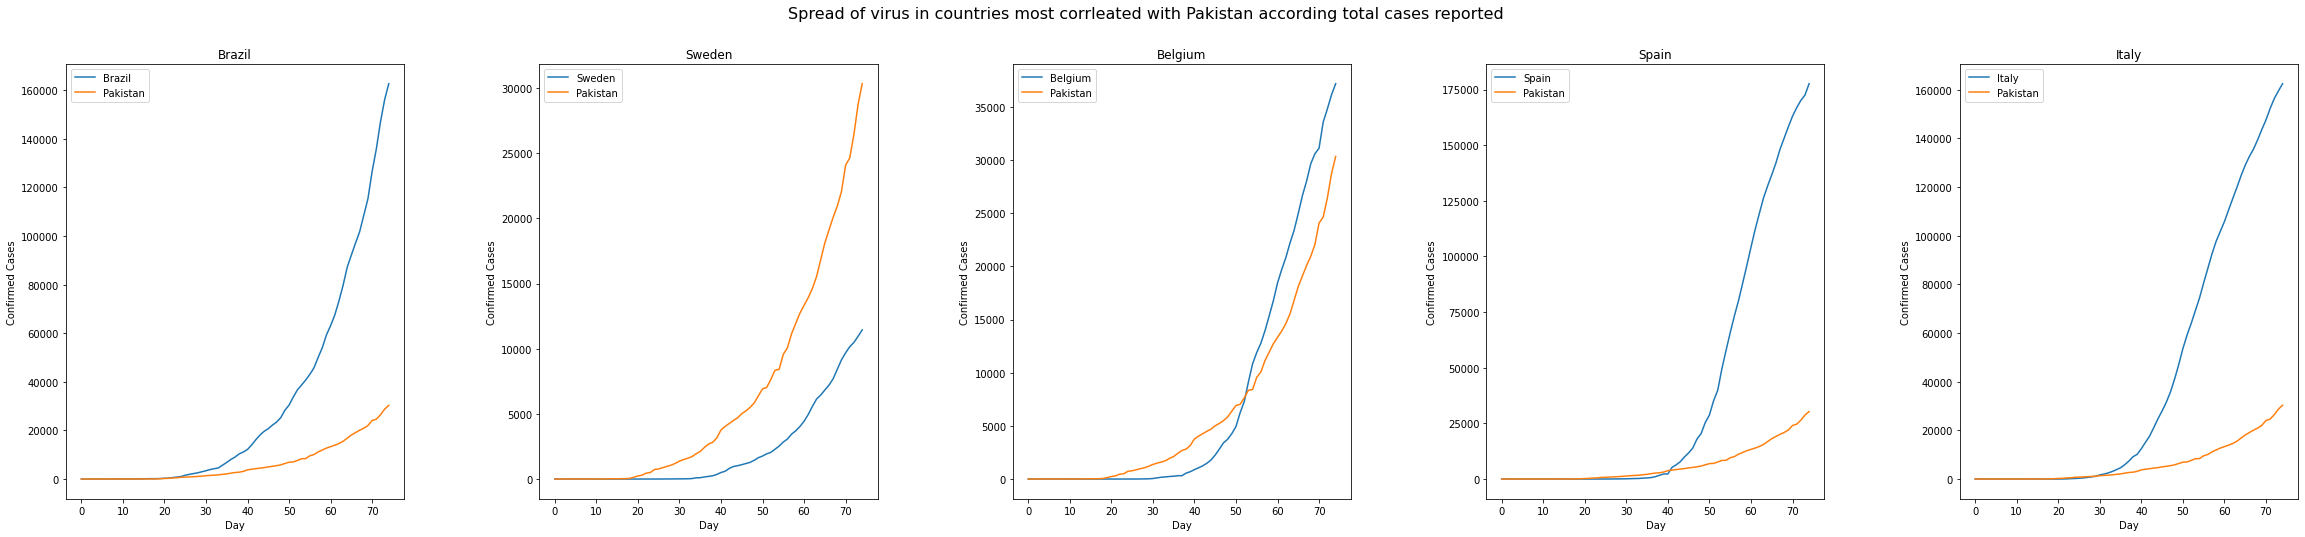

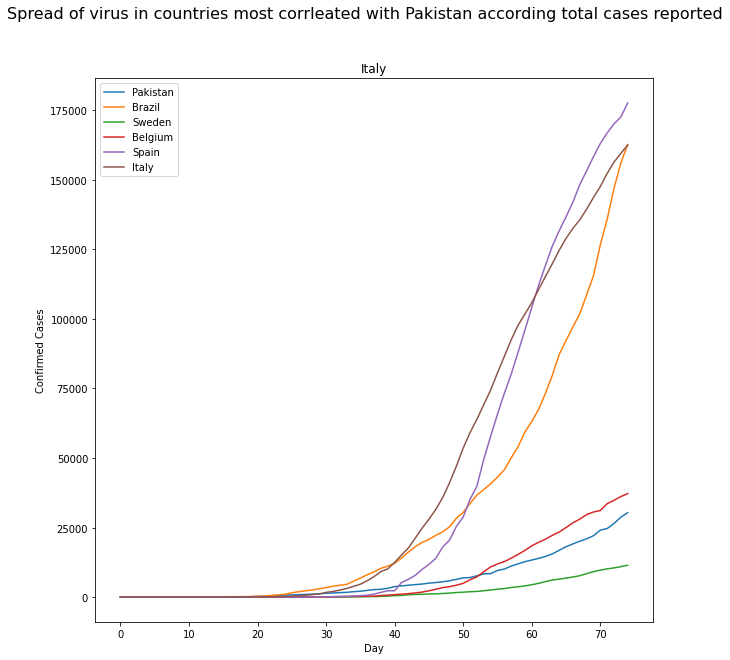

In [564]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE1,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE1,country,dataset)
printTrends(countryTrends,"Spread of virus in countries most corrleated with Pakistan according total cases reported")

## Comparing Countries w.r.t Difference between Cases per day

In [566]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE2,"Pakistan",dataset)
meanDiff = {}
for country in countries:
  countrySeries = getSeries(TYPE2,country,dataset)
  length = len(countrySeries)
  # if (TYPE2 != 2):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 25000): #skipping countries with no cases, less than 1000 cases or with length less than pakistan
    continue
  dat1 = np.array([pakistanSeries[idx] for idx in range(rng)])
  dat2 = np.array([countrySeries[idx] for idx in range(rng)])
  meanDiff[country] = np.mean(np.abs(dat1 - dat2))
meanDiff = {k: v for k, v in sorted(meanDiff.items(),reverse = False, key=lambda item: item[1])}
print(meanDiff)

{'Pakistan': 0.0, 'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665, 'France': 7282.1466666666665, 'United Kingdom': 8871.573333333334, 'Switzerland': 9502.893333333333, 'Germany': 16217.573333333334, 'Brazil': 24645.306666666667, 'US': 29209.68, 'Spain': 33188.96, 'Iran': 34565.46666666667, 'Italy': 35584.64, 'China': 54916.46666666667}


In [567]:
#getting only top 5 countires
relationValues = getTop5(meanDiff,False)
print(relationValues)

{'Belgium': 2429.7733333333335, 'Canada': 3893.4, 'Sweden': 4286.64, 'Russia': 4457.16, 'India': 5306.1466666666665}


Pakistan 75
Belgium 97
Canada 106
Sweden 101
Russia 101
India 102


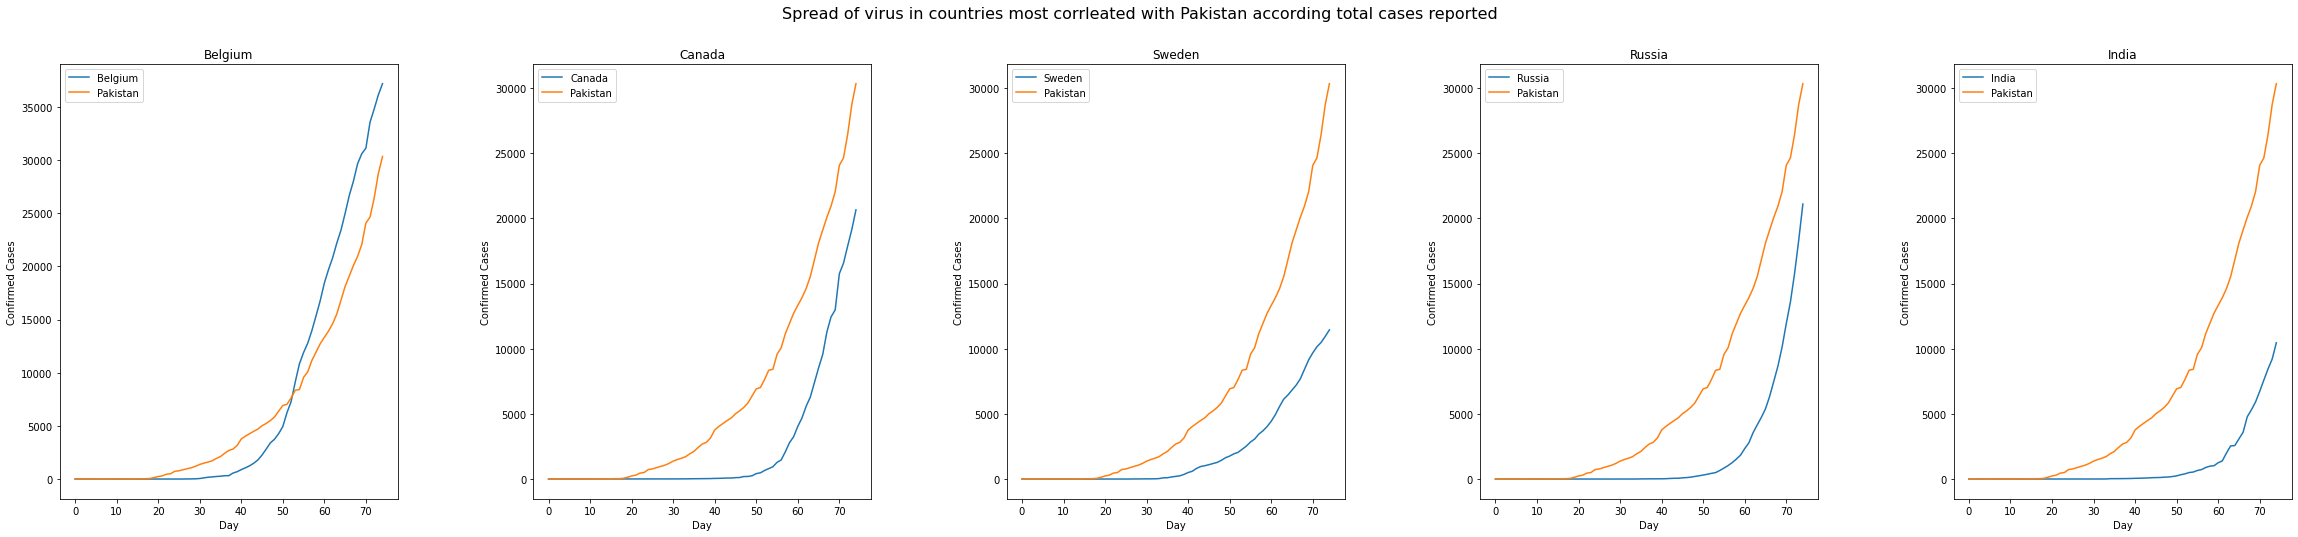

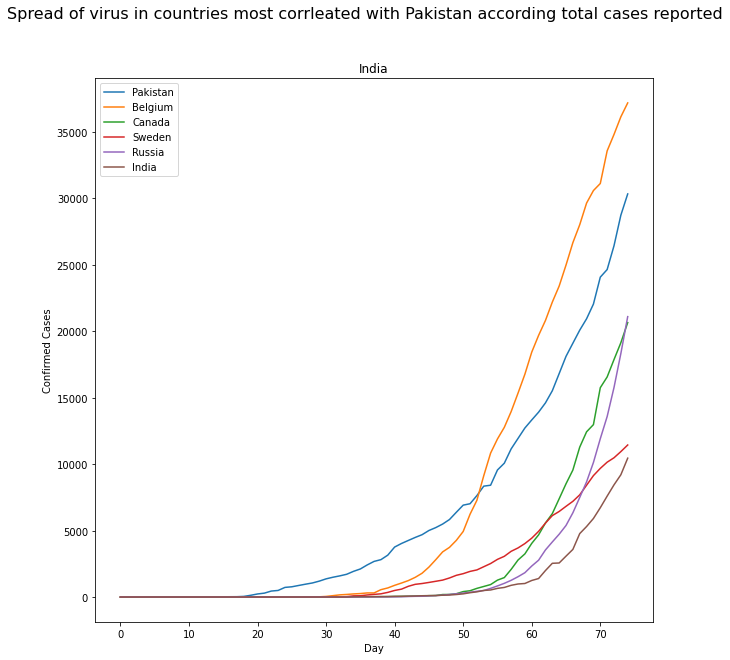

In [568]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Spread of virus in countries most corrleated with Pakistan according total cases reported')

## Final Selection based on both criteria

In [599]:
finalValues = {}
trend2 = {}
countries = list(meanDiff.keys())
for country in countries:
  trend2[country] = meanDiff[country]
maximumValue = (max(trend2.values()))
for country in countries:
  trend2[country] = abs(trend2[country] - maximumValue)
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
maximumValue2 = (max(trend2.values()))
for country in countries:
   trend2[country] = trend2[country]/maximumValue2
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
for country in countries:
  finalValues[country] = correlations[country] * 0.40 +  trend2[country] * 0.60
finalValues = {k: v for k, v in sorted(finalValues.items(),reverse = True, key=lambda item: item[1])}
print(finalValues)

{'Pakistan': 1.0, 'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913, 'France': 0.9069137328091728, 'United Kingdom': 0.8894111453020626, 'Germany': 0.8141526285976779, 'Switzerland': 0.8125089353416399, 'Brazil': 0.7296604733486634, 'US': 0.6409132375949911, 'Spain': 0.6298964800574685, 'Italy': 0.6031313247539418, 'Iran': 0.5821490020917308, 'China': 0.21908099116915758}


In [600]:
#getting only top 5 countires
relationValues = getTop5(finalValues,True)
print(relationValues)

{'Belgium': 0.9686693853769754, 'Sweden': 0.9499187595439108, 'Canada': 0.9333151265002132, 'Russia': 0.9121958631577513, 'India': 0.9097502253979913}


Pakistan 75
Belgium 97
Sweden 101
Canada 106
Russia 101
India 102


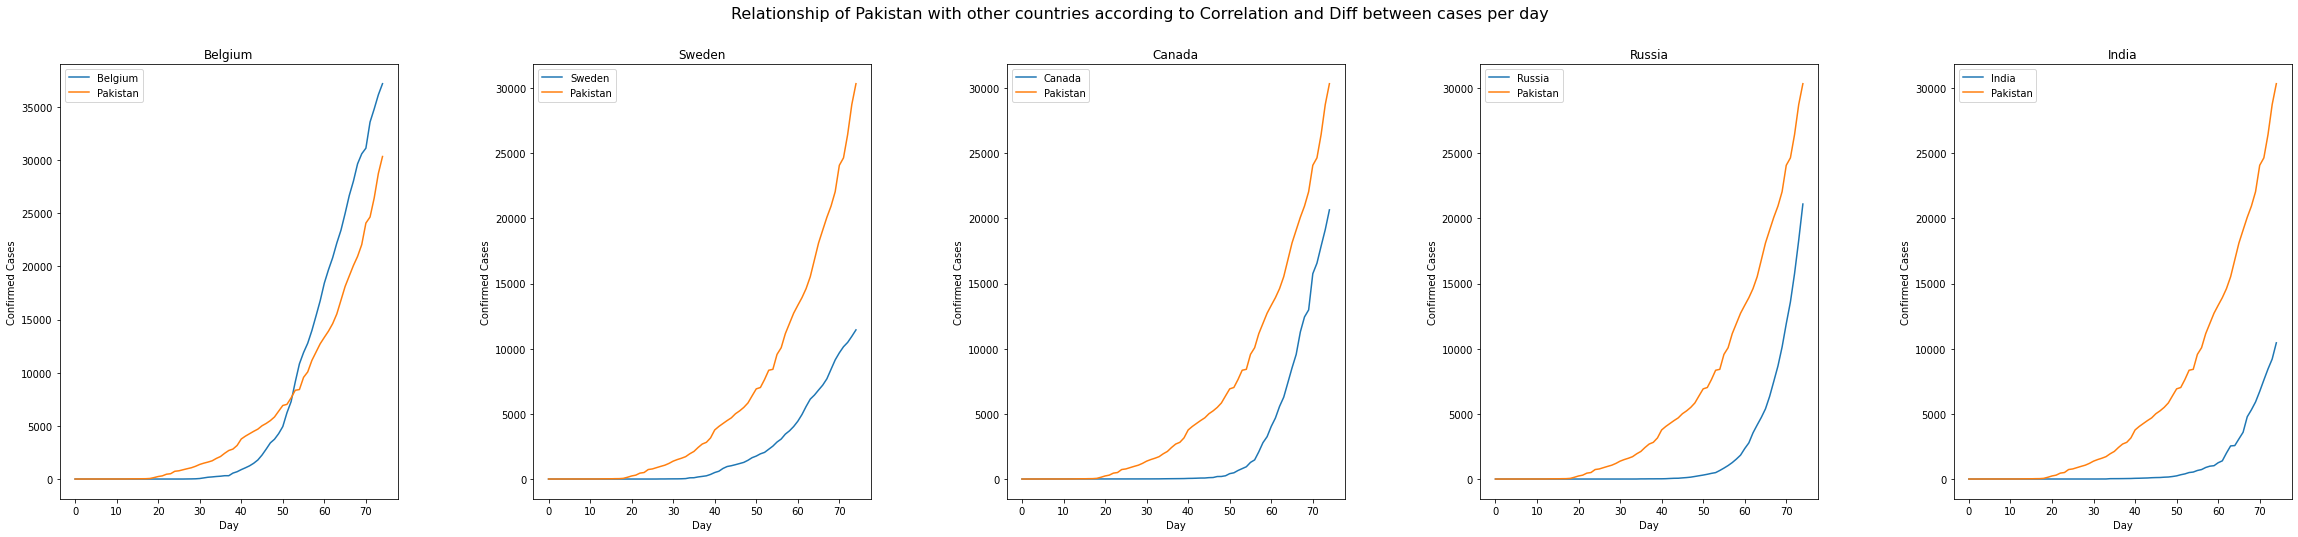

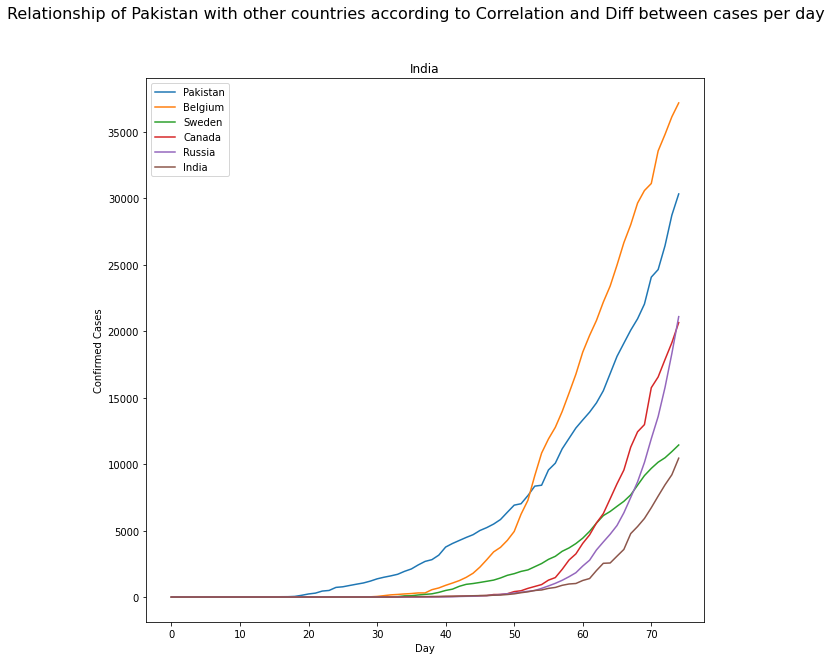

In [601]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Relationship of Pakistan with other countries according to Correlation and Diff between cases per day')

Final selection is dependent upon combining learnings from both approaches, we gave 40% weightage to correlation and 60% to difference approach, based on final score, top 5 countries are.
1. Belgium
2. Sweden
3. Canada
4. Russia
5. India


Please note that the correlations and difference were compared for first 75 days of a country's exposure to the virus, since Pakistan has 75 days between first case until 10th May.  
Including any more days into our preliminary analysis would be actually cheating as then we would actually be peaking into the future and finiding correlated countries that are bound to give more acurate predictions, as we have already seen their trend beyond 10th May.


# Forecasting

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [95]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

Country/Region      Lat     Long  1/22/20  ...  5/24/20  5/25/20  5/26/20  5/27/20
0    Afghanistan  33.0000  65.0000        0  ...    10582    11173    11831    12456
1        Albania  41.1533  20.1683        0  ...      998     1004     1029     1050
2        Algeria  28.0339   1.6596        0  ...     8306     8503     8697     8857
3        Andorra  42.5063   1.5218        0  ...      762      763      763      763
4         Angola -11.2027  17.8739        0  ...       69       70       70       71

[5 rows x 130 columns]

In [0]:
# Utility functions
def getTimeSeriesTillDate(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = series.sum(axis = 0, skipna = True)
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def convertSeriesToActiveCases(series):
  newSeries = []
  newSeries.append(series[0])
  for i in range(len(series)-1):
    diff = series[i+1] - series[i] 
    newSeries.append(diff)
  return newSeries

def getDailyCaseSeries(country,dataset,date = '5/10/20',crop = True):
  series = getTimeSeriesTillDate(country,dataset,date,crop)
  return convertSeriesToActiveCases(series)


## Approach 1 (LSTM trained on non-stationary series)

The analysis below is based on top 5 countires picked via the observations above.  
- Each country is used to predict cases from 10th May to 27th May period of pakistan(training is done for first 74 days). Test RMSE are computed in this case for cases between 10th and 27th may, and predicted cases
-  Each country is also used to predict cases from 27th May to 27th June period of pakistan(training is done for first 92 days). No validation is done as we've assumed this is the true future, and we have no data of these days
- Each country data is trained on the same model, with same configurations
- The  daily cases series is kept non-stationary in this case, as LSTM have no pre-condition of stationary series

In [631]:
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
register_matplotlib_converters()
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
pred_trend = {}
test_rmse = {}
train_rmse = {}
pak_rmse = {}
pred_trend_fut = {}

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def train_LSTM_model(model,epochs,train_data,test_data = None):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_hist = []
  test_hist = []
  for i in range(epochs):
    train_loss = 0
    test_loss = 0
    for seq, labels in train_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        train_loss += single_loss.item()
        single_loss.backward()
        optimizer.step()

    train_loss = train_loss/len(train_data) 
    train_hist.append(train_loss)
    if test_data is not None:
      with torch.no_grad():
        for seq, labels in test_data:
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
          y_pred = model(seq)
          single_loss = loss_function(y_pred, labels)
          test_loss += single_loss.item()
        test_loss = test_loss/len(test_data) 
        test_hist.append(test_loss)
      if i % 5 == 0:
        print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
    elif i % 5 == 0:
      print(f'Epoch {i} train loss: {train_loss}')
  if test_data is not None:
    print(f'Epoch {i} train loss: {train_loss} test loss: {test_loss}')
  else:
    print(f'Epoch {i} train loss: {train_loss}')
  return model.eval(),train_hist,test_hist

In [0]:
def create_sequences(series, window):
    sequences = []
    for i in range(len(series)-window):
        sample_seq = series[i:i+window]
        label = series[i+window:i+window+1]
        sequences.append((sample_seq ,label))
    return sequences

### Belgium


#### Prediction from 10th May to 27th May

In [635]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

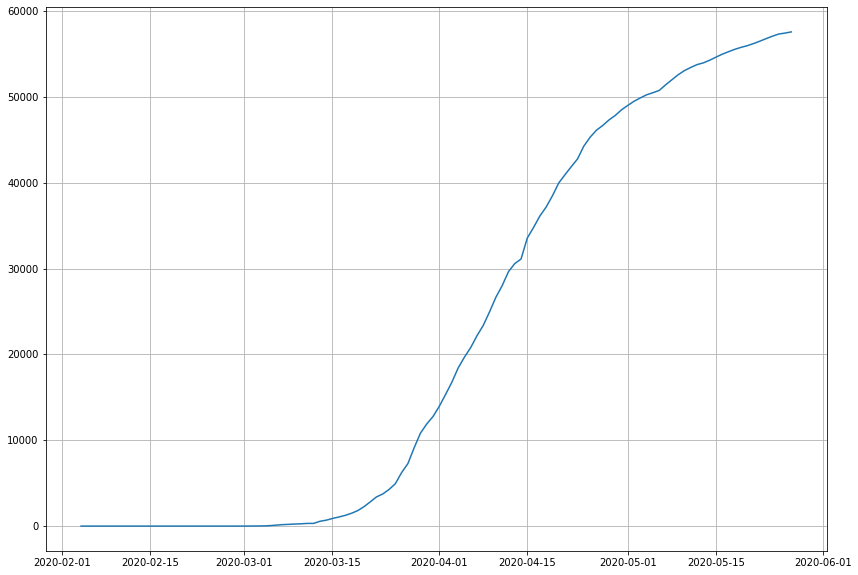

In [636]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

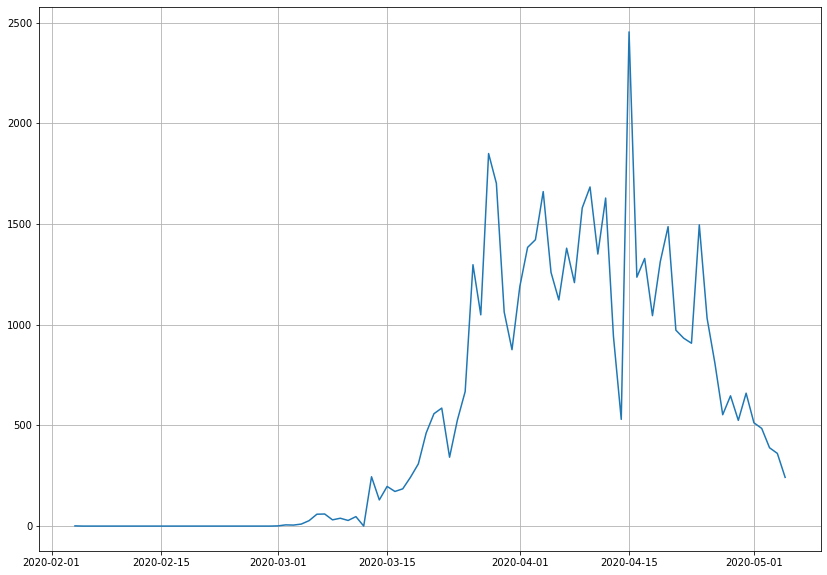

In [637]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

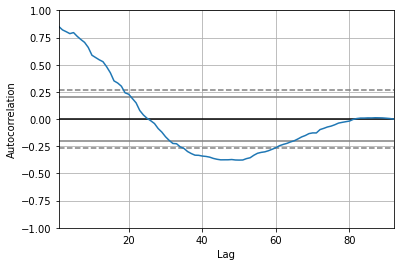

In [638]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 5, as the values are most correalted for that range

In [639]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [641]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [642]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,10,train_seq,test_seq)

Epoch 0 train loss: 0.014227246817958011 test loss: 0.06744433213801433
Epoch 5 train loss: 0.024331687542871804 test loss: 0.025250299096417923
Epoch 9 train loss: 0.018733856075349258 test loss: 0.02552260427425305


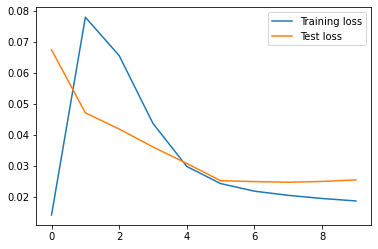

In [643]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [644]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.12233895808458328, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12228673696517944, 0.12238143384456635, 0.12293720245361328, 0.12332476675510406, 0.12413320690393448, 0.12644150853157043, 0.1314290463924408, 0.1356136053800583, 0.13651251792907715, 0.13779474794864655, 0.13707442581653595, 0.136829674243927, 0.13213138282299042, 0.15266886353492737, 0.15904563665390015, 0.1714579463005066, 0.1787879914045334, 0.18832869827747345, 0.19128987193107605, 0.2051168531179428, 0.22860406339168549, 0.2586934268474579, 0.2861410081386566, 0.2836146950721741, 0.29680147767066956, 0.31465455889701843, 0.38

In [645]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1696 Actual 1313
Predicted 1896 Actual 1487
Predicted 1974 Actual 973
Predicted 2075 Actual 933
Predicted 2170 Actual 908
Predicted 2261 Actual 1496
Predicted 2323 Actual 1032
Predicted 2367 Actual 809
Predicted 2402 Actual 553
Predicted 2429 Actual 647
Predicted 2449 Actual 525
Predicted 2464 Actual 660
Predicted 2475 Actual 513
Predicted 2483 Actual 485
Predicted 2489 Actual 389
Predicted 2493 Actual 361
Predicted 2497 Actual 242
Train RMSE =  343.97605611511824
Test RMSE =  1615.2229892473442
RMSE Against Pakistan =  933.9438323195014


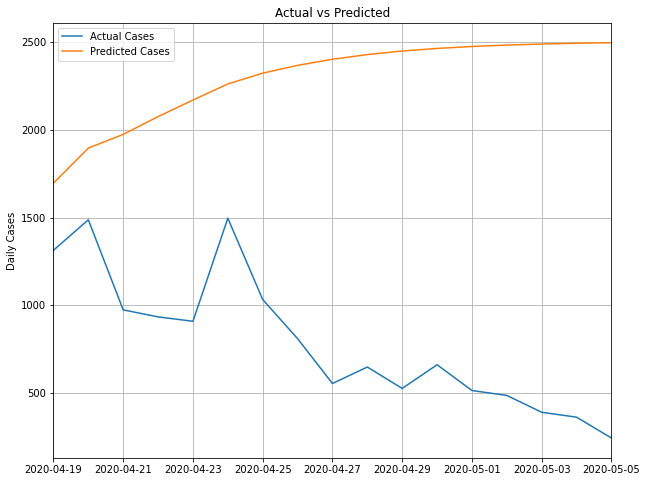

In [646]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

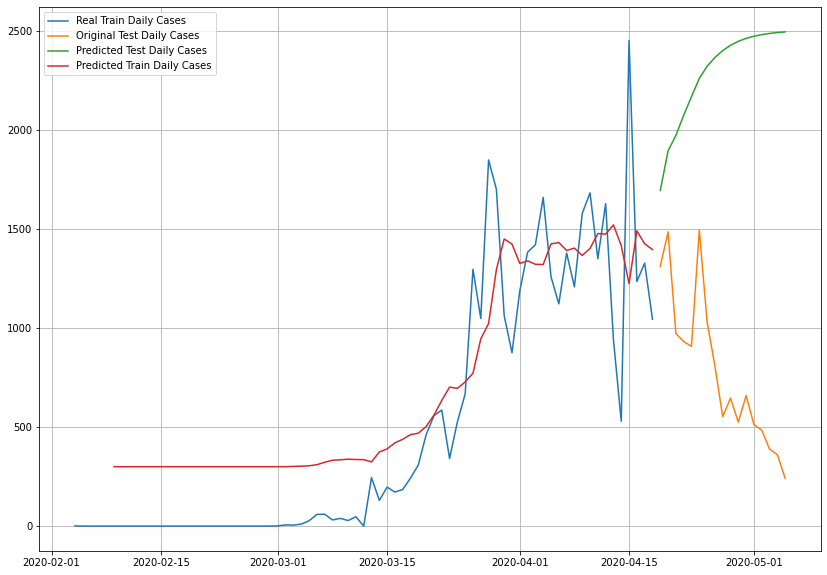

In [647]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

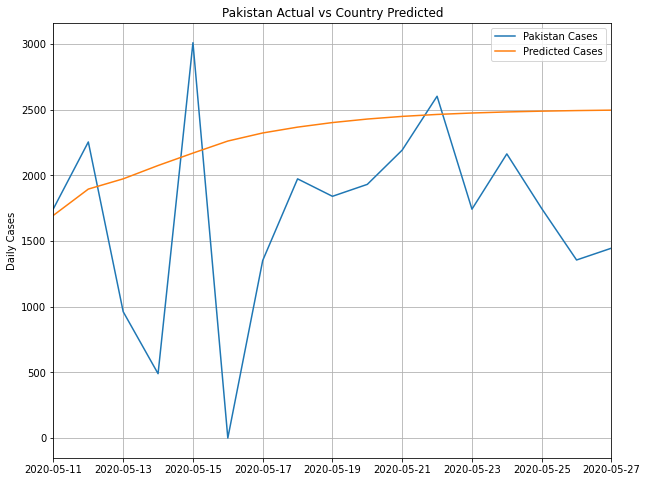

In [648]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [649]:
#CONFIGURATIONS
COUNTRY = "Belgium"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

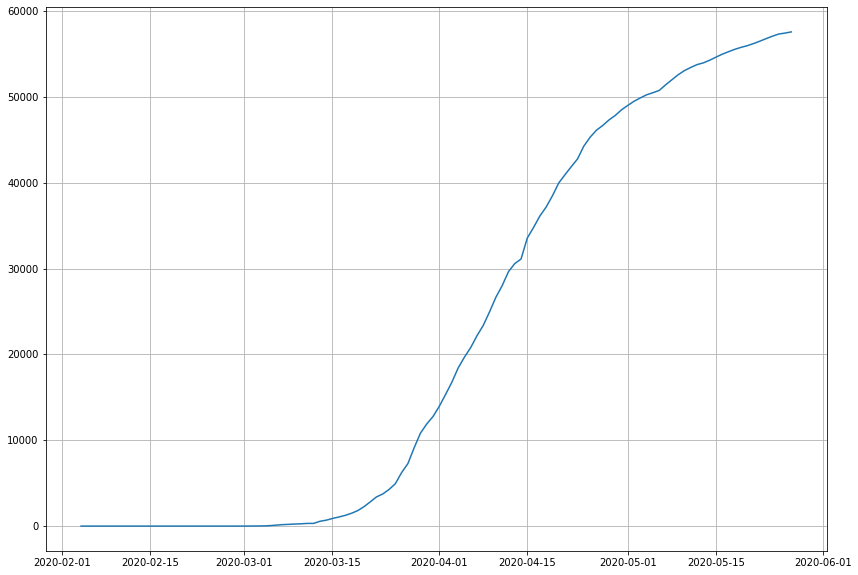

In [650]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

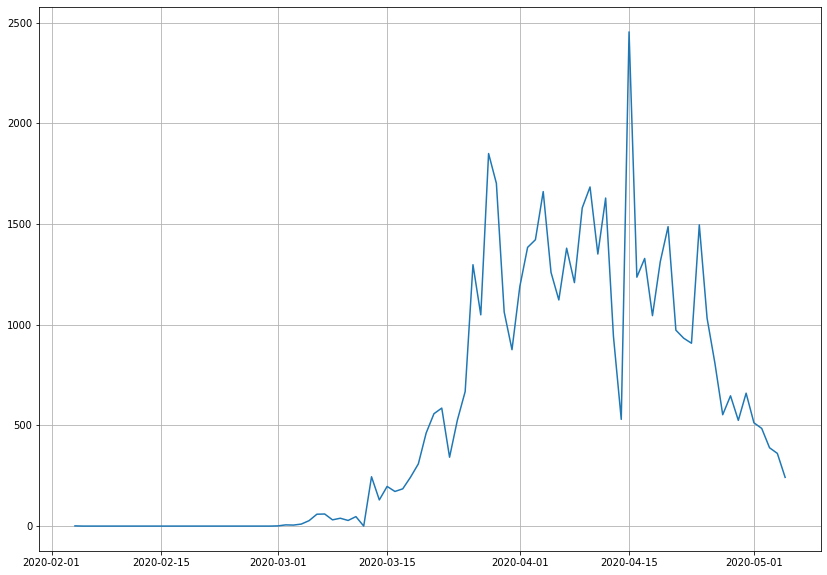

In [651]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

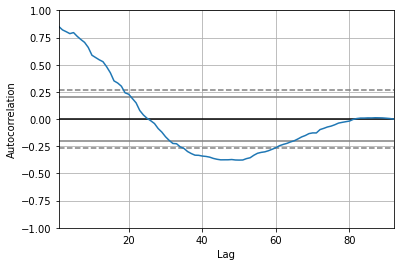

In [652]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Belgium, a suitable window size might be around 10, as the values are most correalted for that range

In [653]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [655]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.

In [656]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,50,train_seq)

Epoch 0 train loss: 0.02119815832507477
Epoch 5 train loss: 0.039743982999517
Epoch 10 train loss: 0.021031841036892072
Epoch 15 train loss: 0.01808768042107337
Epoch 20 train loss: 0.01711155113495041
Epoch 25 train loss: 0.016781246368767575
Epoch 30 train loss: 0.016172083819309378
Epoch 35 train loss: 0.015356413851664067
Epoch 40 train loss: 0.014943172190328476
Epoch 45 train loss: 0.013516278360977647
Epoch 49 train loss: 0.013616703136515909


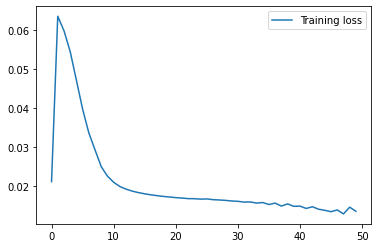

In [657]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [658]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.020395934581756592, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020384520292282104, -0.020072638988494873, -0.018199771642684937, -0.016738951206207275, -0.014367669820785522, -0.0072633326053619385, 0.008832454681396484, 0.022448644042015076, 0.021504253149032593, 0.018160223960876465, 0.010959163308143616, 0.01040765643119812, -0.0020749568939208984, 0.06172122061252594, 0.09012830257415771, 0.11804728209972382, 0.12716533243656158, 0.1300622969865799, 0.14437778294086456, 0.17350807785987854, 0.2359960973262787, 0.30205240845680237, 0.3439168334007263, 0.3103370666503906, 0.3197380304336548, 0.34693005681037903, 0.49220824241638184, 0.5040587782859802, 0.63005012

In [659]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
actual_predictions[actual_predictions < 0] = 0
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  263.17515792834473


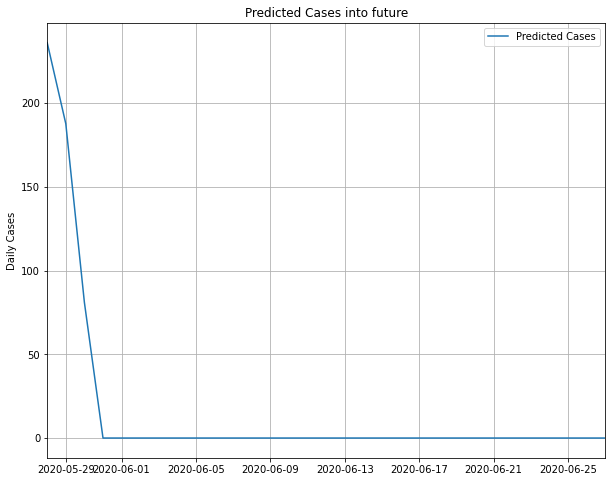

In [660]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

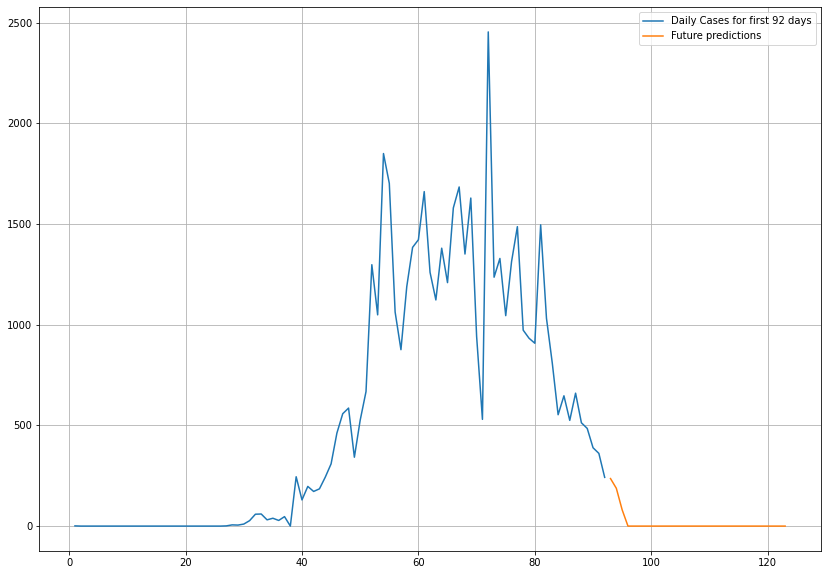

In [661]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Sweden


#### Predictions from 10th May to 27th May

In [662]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

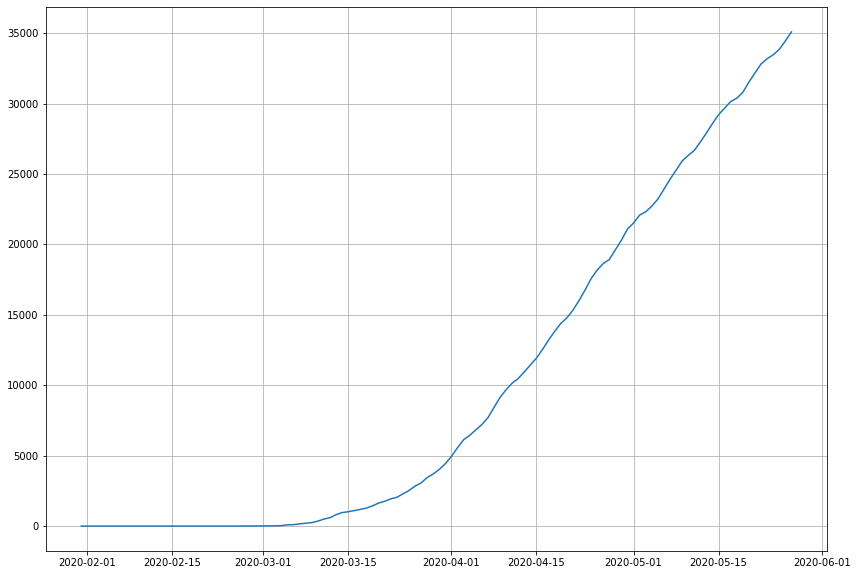

In [663]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

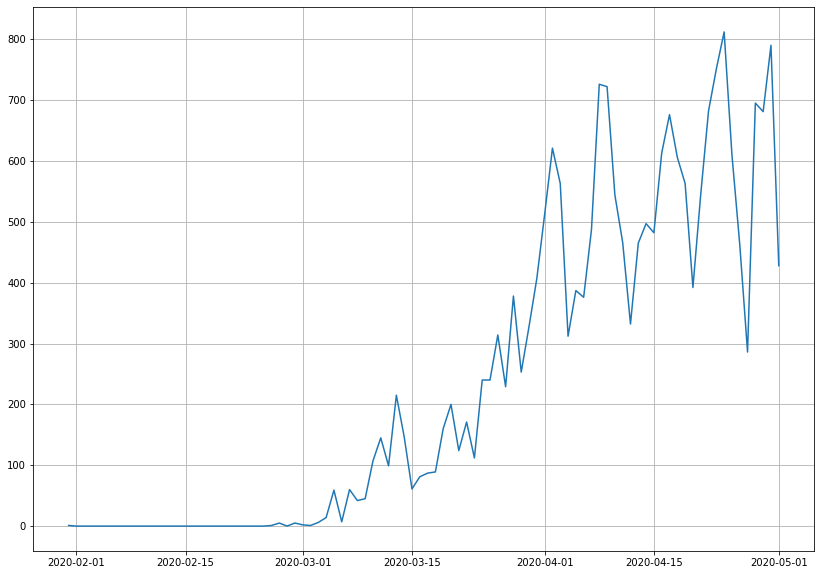

In [664]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

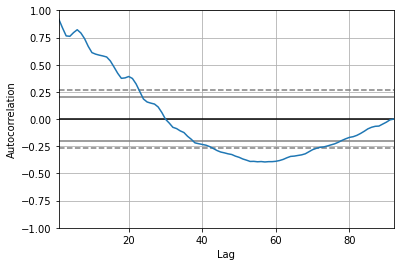

In [665]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 5, as the values are most correalted for that range

In [666]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [668]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 

In [669]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,30,train_seq,test_seq)

Epoch 0 train loss: 0.011860042690381364 test loss: 0.04690100655231314
Epoch 5 train loss: 0.023594430313556864 test loss: 0.052572557654154174
Epoch 10 train loss: 0.012143684739407945 test loss: 0.04660295706707984
Epoch 15 train loss: 0.009142534276007553 test loss: 0.04425646530580707
Epoch 20 train loss: 0.00828602647160283 test loss: 0.041413929352226354
Epoch 25 train loss: 0.007738390598696502 test loss: 0.034942473915483184
Epoch 29 train loss: 0.006889007723559969 test loss: 0.026201402821849722


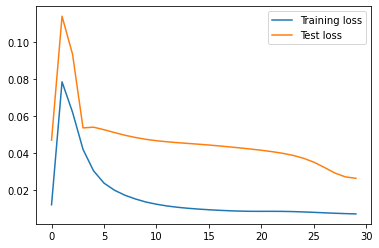

In [670]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [671]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.08229121565818787, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08274528384208679, -0.08210323750972748, -0.07906635105609894, -0.07997649908065796, -0.07686920464038849, -0.07641857862472534, -0.07670177519321442, -0.07527418434619904, -0.06731268763542175, -0.03381280228495598, -0.041832808405160904, -0.005649115890264511, 0.007583402097225189, 0.020566178485751152, 0.05662635341286659, 0.12687356770038605, 0.12797032296657562, 0.22979483008384705, 0.24662813544273376, 0.19016680121421814, 0.17618431150913239, 0.1807791292667389, 0.13526521623134613, 0.16193151473999023, 

In [672]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 700 Actual 482
Predicted 783 Actual 613
Predicted 753 Actual 676
Predicted 633 Actual 606
Predicted 475 Actual 563
Predicted 440 Actual 392
Predicted 577 Actual 545
Predicted 775 Actual 682
Predicted 918 Actual 751
Predicted 863 Actual 812
Predicted 652 Actual 610
Predicted 420 Actual 463
Predicted 362 Actual 286
Predicted 563 Actual 695
Predicted 805 Actual 681
Predicted 974 Actual 790
Predicted 894 Actual 428
Train RMSE =  77.57641342871146
Test RMSE =  158.6883755421491
RMSE Against Pakistan =  1258.3359014339262


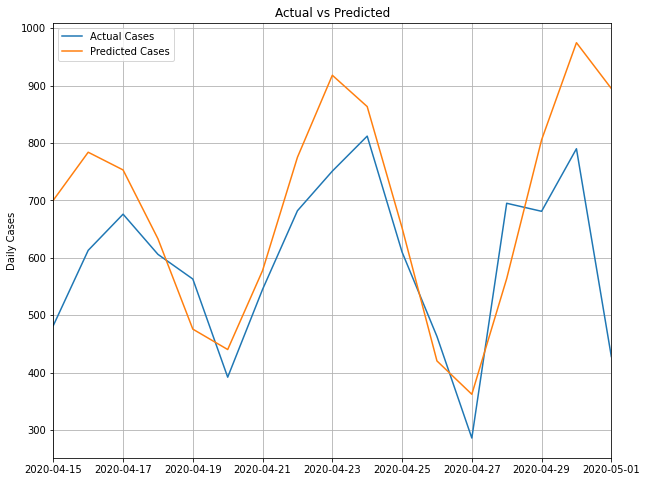

In [673]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

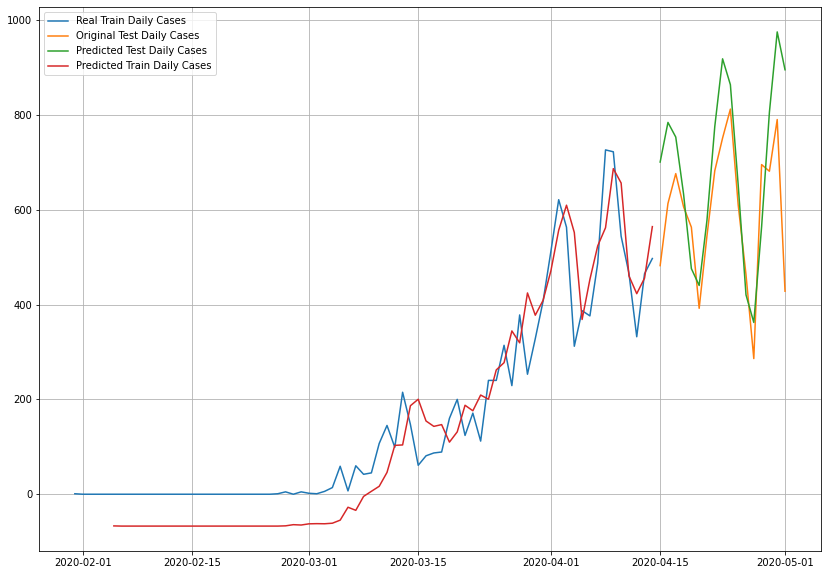

In [674]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

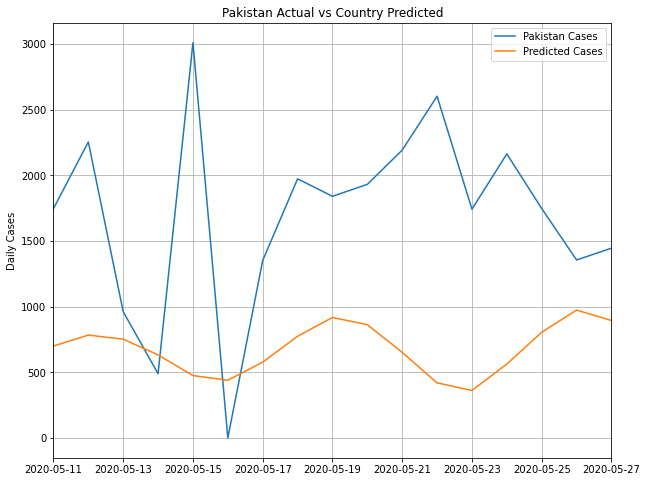

In [675]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [676]:
#CONFIGURATIONS
COUNTRY = "Sweden"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

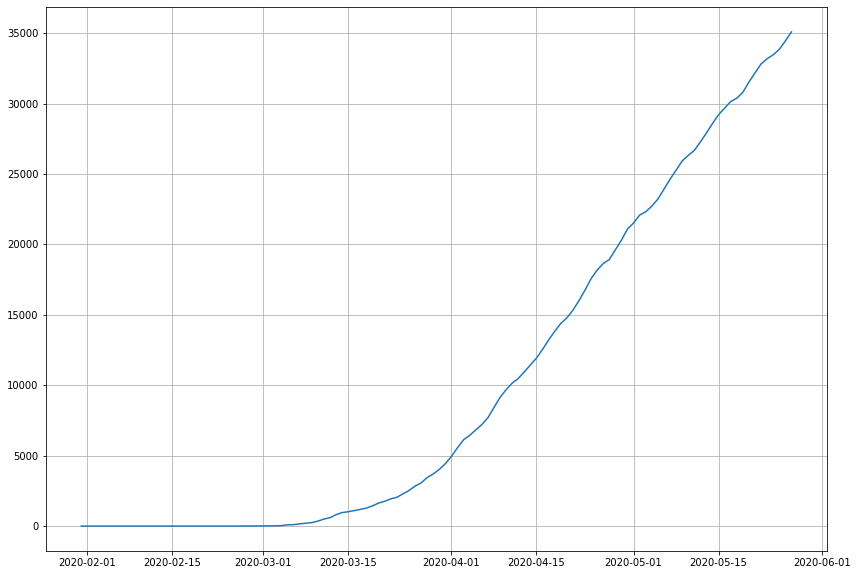

In [677]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

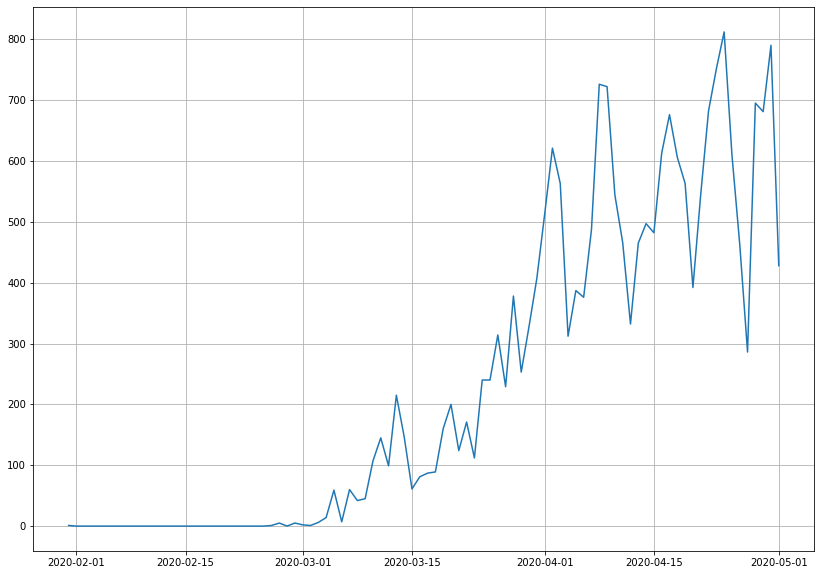

In [678]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

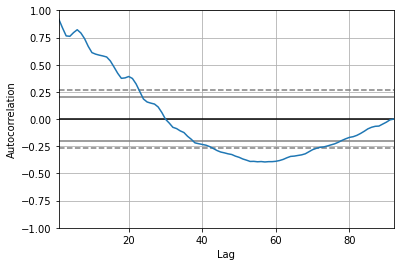

In [679]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Sweden, a suitable window size might be around 7, as the values are most correalted for that range

In [680]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [682]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0012, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [683]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,50,train_seq)

Epoch 0 train loss: 0.018474269410091223
Epoch 5 train loss: 0.03125434055728767
Epoch 10 train loss: 0.015694868604002883
Epoch 15 train loss: 0.013142003320729814
Epoch 20 train loss: 0.010744752559660623
Epoch 25 train loss: 0.010359393586283178
Epoch 30 train loss: 0.009603317532675206
Epoch 35 train loss: 0.009105099454553938
Epoch 40 train loss: 0.008827613385681296
Epoch 45 train loss: 0.00866852415295965
Epoch 49 train loss: 0.008580984080670177


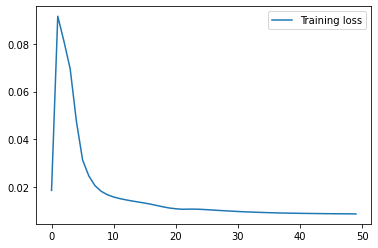

In [684]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [685]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.007126867771148682, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007013082504272461, 0.007490403950214386, 0.009723260998725891, 0.008806221187114716, 0.010455630719661713, 0.010307155549526215, 0.009733662009239197, 0.011882893741130829, 0.01722148060798645, 0.042125094681978226, 0.03367605805397034, 0.05213456600904465, 0.05799984559416771, 0.06383202224969864, 0.10004401206970215, 0.144578218460083, 0.14278727769851685, 0.20955035090446472, 0.21535634994506836, 0.175009086728096, 0.17327290773391724, 0.17951875925064087, 0.17563563585281372, 0.21228842437267303, 0.2327967882156372, 0.20645996928215027, 0.22681885957

In [686]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  72.30792577844538


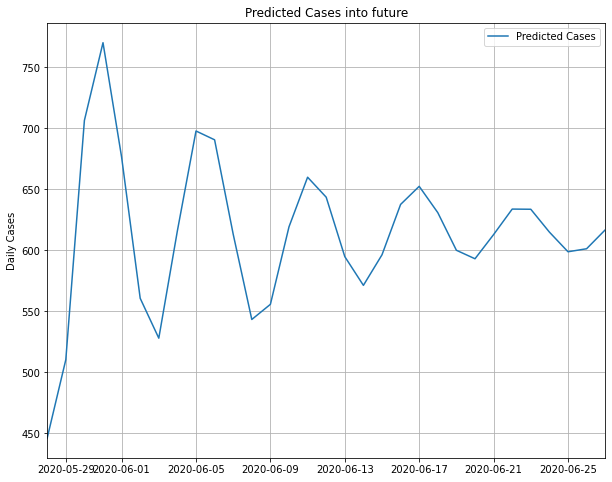

In [687]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

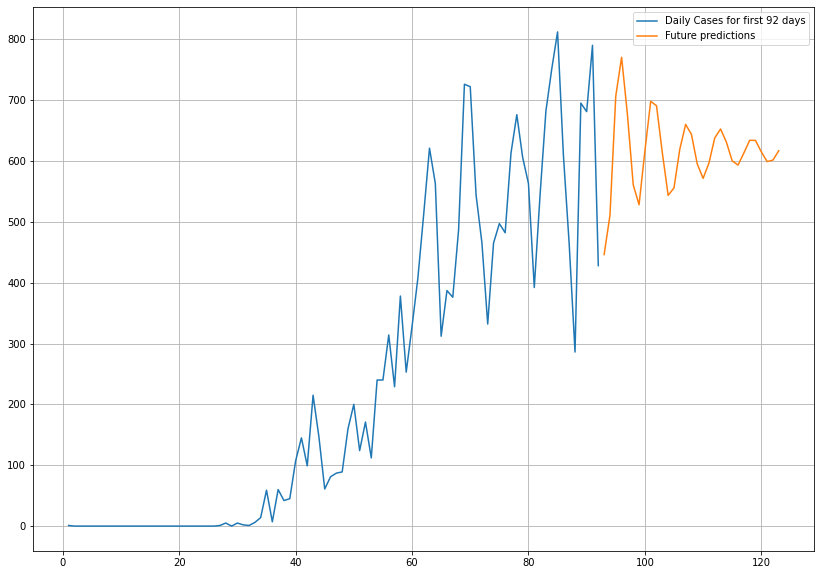

In [688]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### India


#### Predictions from 10th May to 27th May

In [689]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

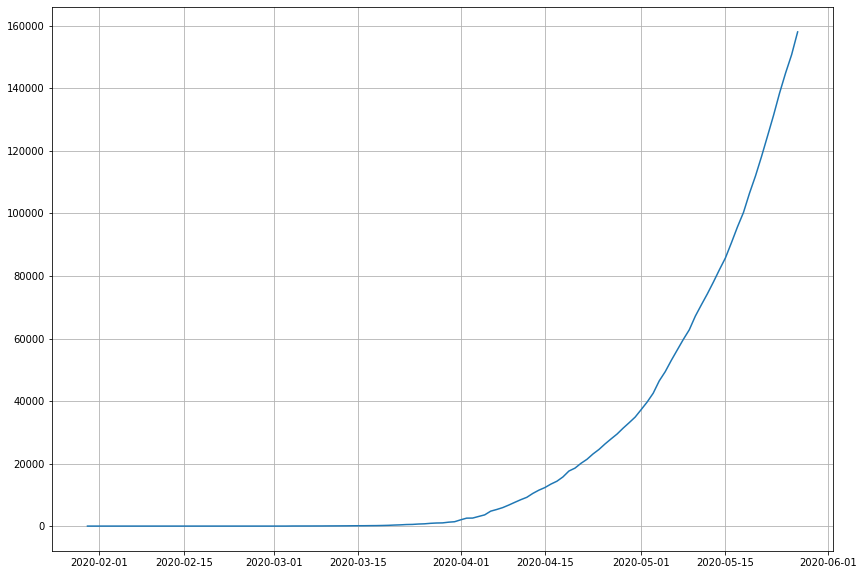

In [690]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

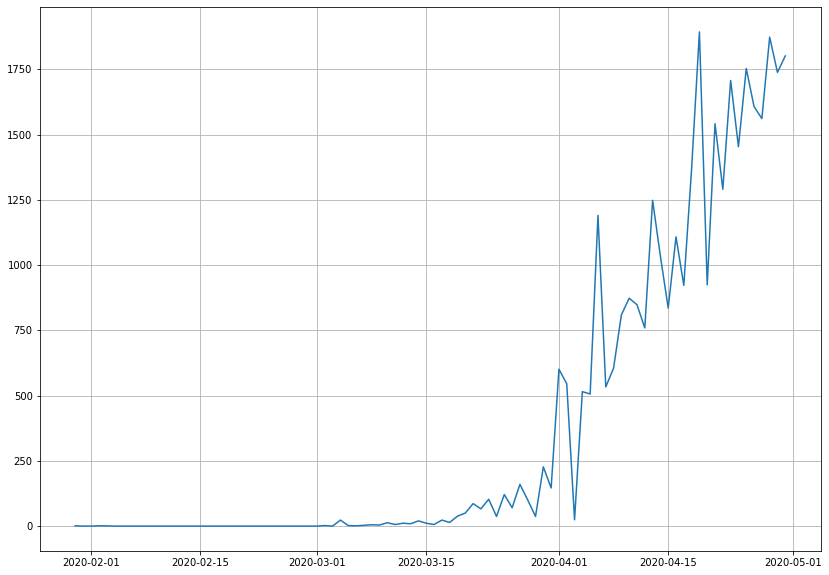

In [691]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

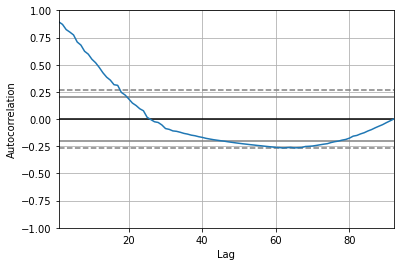

In [692]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [693]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [695]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0008, 0.0000, 0.0000, 0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0008, 0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 

In [696]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,20,train_seq,test_seq)

Epoch 0 train loss: 0.025736851905369906 test loss: 0.3552271979195731
Epoch 5 train loss: 0.02362828551509805 test loss: 0.32215567997523714
Epoch 10 train loss: 0.027994747966009797 test loss: 0.22869419838700975
Epoch 15 train loss: 0.01622788197125916 test loss: 0.04020393320492336
Epoch 19 train loss: 0.013422278830223537 test loss: 0.03995820417601083


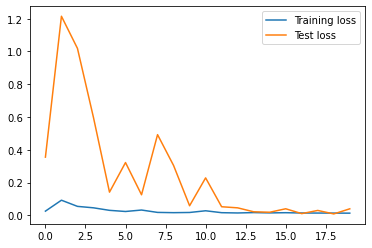

In [697]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [698]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.08035852760076523, 0.08032495528459549, 0.08030679821968079, 0.08029904961585999, 0.08029782027006149, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08029856532812119, 0.08069314807653427, 0.08067722618579865, 0.0851585641503334, 0.0852811262011528, 0.08468009531497955, 0.08415374159812927, 0.08399385213851929, 0.0837424099445343, 0.08537331223487854, 0.08562576770782471, 0.08669687807559967, 0.08717874437570572, 0.08964988589286804, 0.09006782621145248, 0.089143767952919, 0.09138844907283783, 0.09178412705659866, 0.0967191681265831, 0.10366000235080719, 0.11681829392910004, 0.12425648421049118, 0.13665258884429932, 0.13337410986423492, 0.14481309056282043, 

In [699]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1003 Actual 1034
Predicted 1036 Actual 835
Predicted 1068 Actual 1108
Predicted 1092 Actual 922
Predicted 1117 Actual 1370
Predicted 1139 Actual 1892
Predicted 1158 Actual 924
Predicted 1176 Actual 1541
Predicted 1192 Actual 1290
Predicted 1208 Actual 1707
Predicted 1221 Actual 1453
Predicted 1234 Actual 1753
Predicted 1245 Actual 1607
Predicted 1255 Actual 1561
Predicted 1265 Actual 1873
Predicted 1273 Actual 1738
Predicted 1281 Actual 1800
Train RMSE =  153.52191988814758
Test RMSE =  387.4113700084801
RMSE Against Pakistan =  876.8017813415294


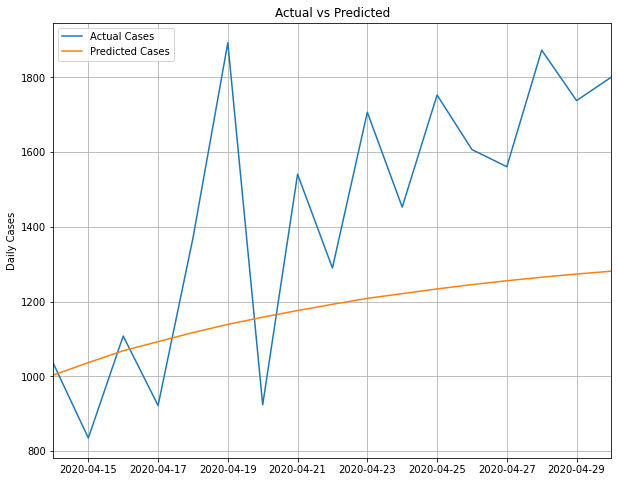

In [700]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

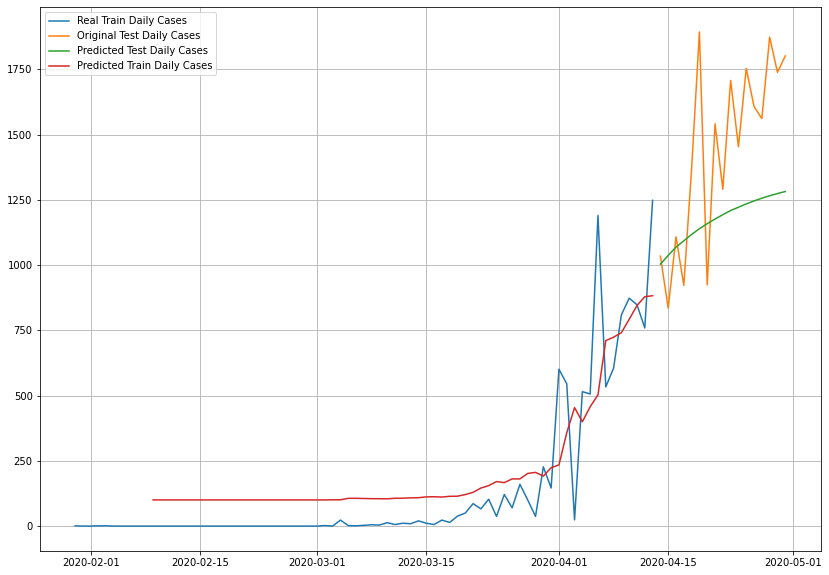

In [701]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

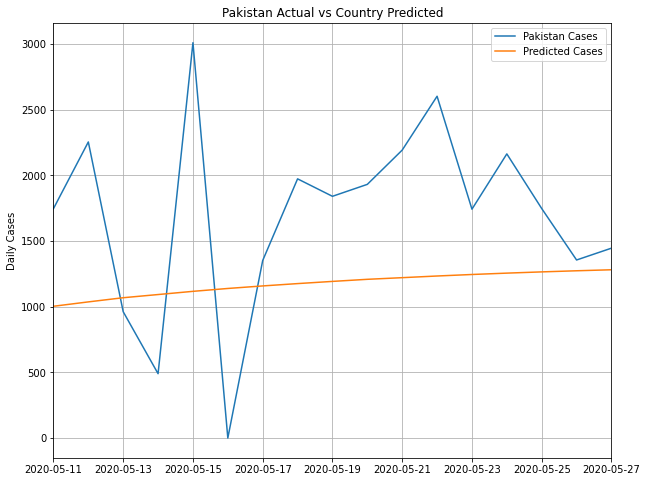

In [702]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [703]:
#CONFIGURATIONS
COUNTRY = "India"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

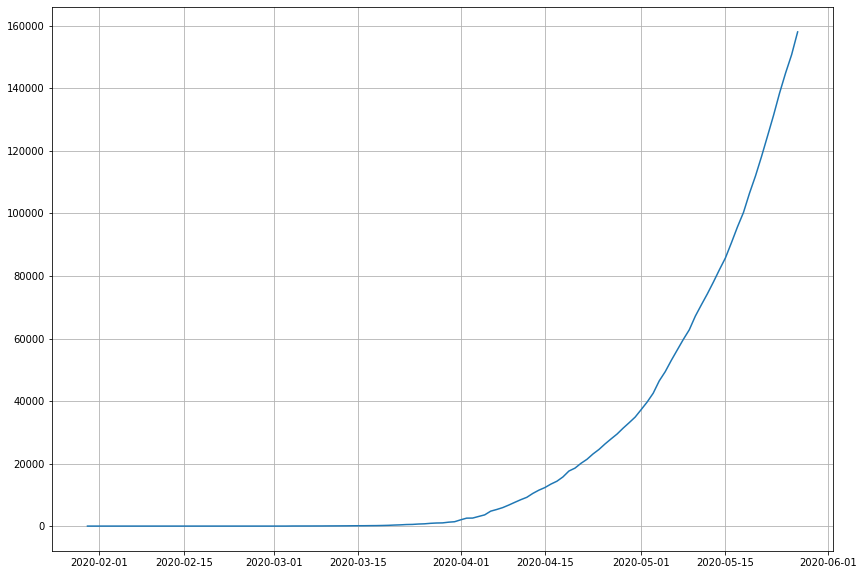

In [704]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

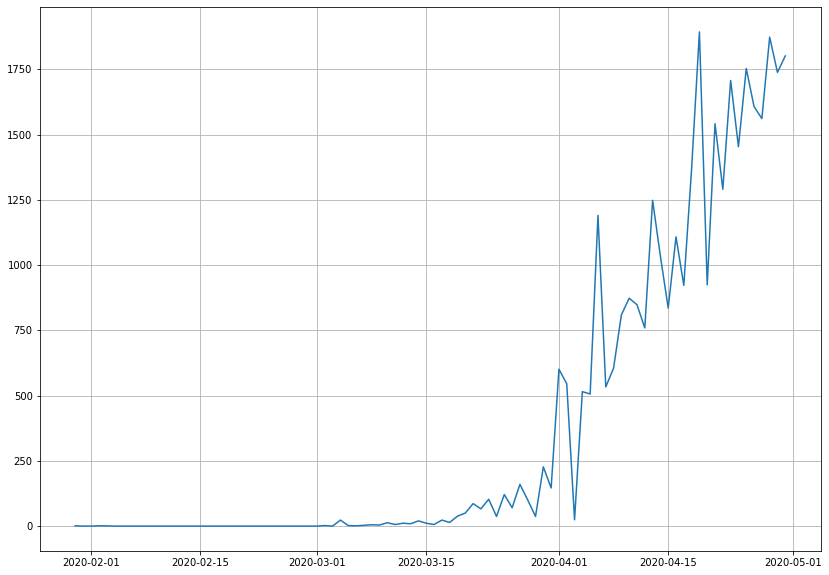

In [705]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

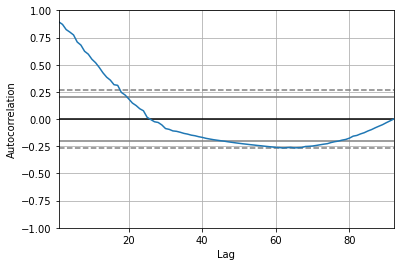

In [706]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for India, a suitable window size might be around 10, as the values are most correalted for that range

In [707]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 10
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [709]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0005, 0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0000, 0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 

In [710]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,50,train_seq)

Epoch 0 train loss: 0.01220863205439744
Epoch 5 train loss: 0.020692679523829322
Epoch 10 train loss: 0.00932441367027012
Epoch 15 train loss: 0.008419489809910915
Epoch 20 train loss: 0.008532727865111533
Epoch 25 train loss: 0.008502304074255215
Epoch 30 train loss: 0.008186288114026543
Epoch 35 train loss: 0.007774801803579088
Epoch 40 train loss: 0.00924424030736759
Epoch 45 train loss: 0.007794294178088981
Epoch 49 train loss: 0.007379651814303764


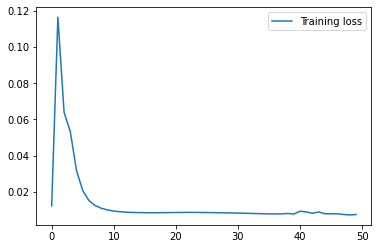

In [711]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [712]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.08411039412021637, 0.08407822251319885, 0.08405309915542603, 0.08405295014381409, 0.08408154547214508, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08410511910915375, 0.08419433236122131, 0.0843263566493988, 0.08540058881044388, 0.08697493374347687, 0.08765393495559692, 0.08743956685066223, 0.0868307501077652, 0.08622100949287415, 0.08617205917835236, 0.08662460744380951, 0.08728070557117462, 0.08793111145496368, 0.08918388187885284, 0.08999663591384888, 0.09009555727243423, 0.09018824994564056, 0.09062221646308899, 0.09192020446062088, 0.09523230791091919, 0.10112540423870087, 0.10852283239364624, 0.11590975522994995, 0.1207917183637619, 0.1228256672620773

In [713]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  185.37059657596623


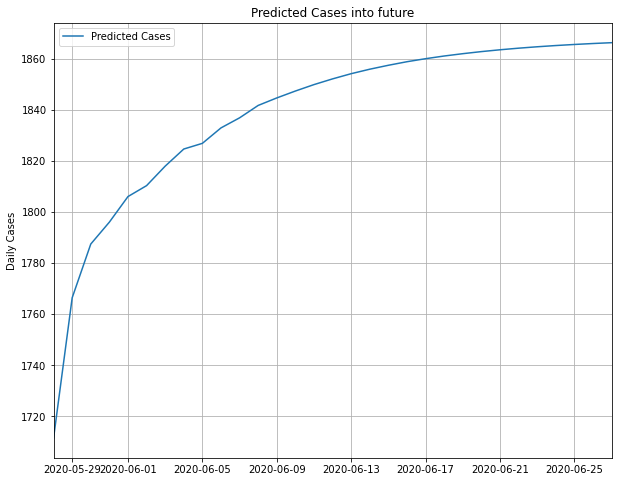

In [714]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

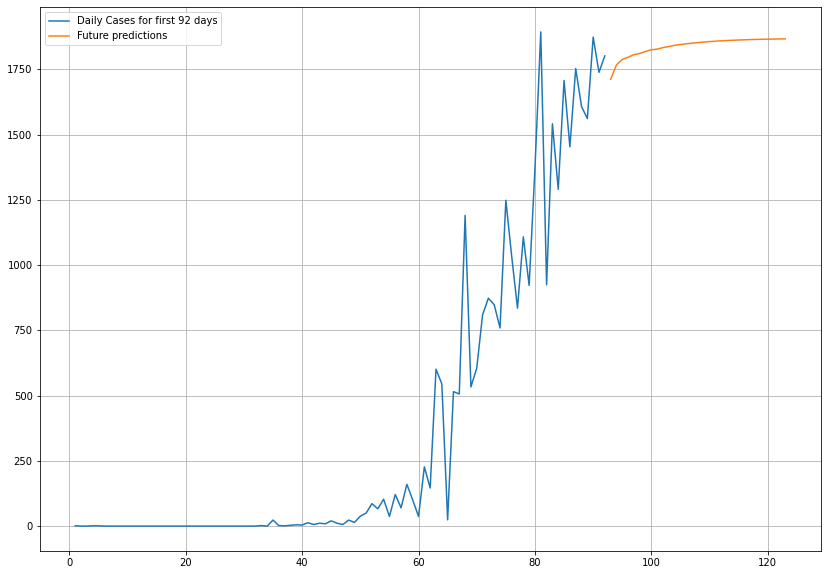

In [715]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Russia


#### Predictions from 10th May to 27th May

In [716]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

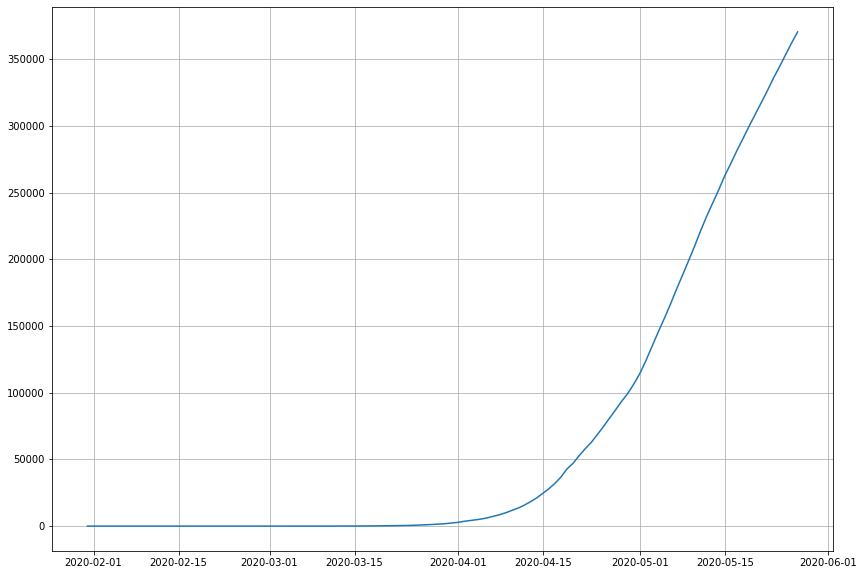

In [717]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

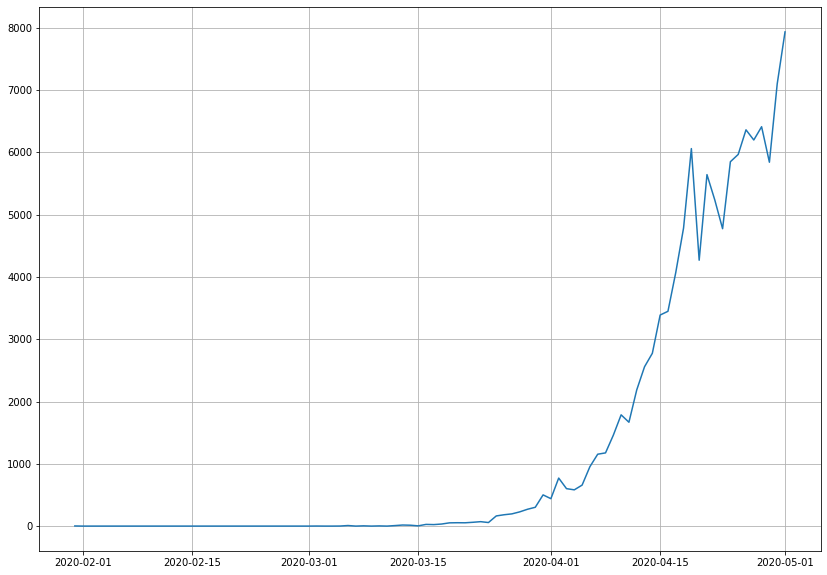

In [718]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

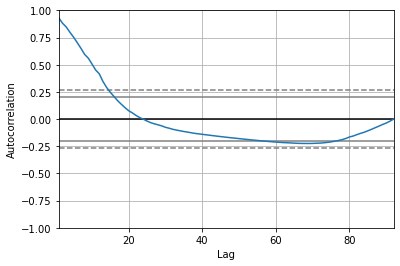

In [719]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [720]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [722]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [723]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,25,train_seq,test_seq)

Epoch 0 train loss: 0.0017161117597363658 test loss: 0.7476158380508423
Epoch 5 train loss: 0.010060007712501614 test loss: 1.887903618812561
Epoch 10 train loss: 0.0026987434775662678 test loss: 0.6922165021300316
Epoch 15 train loss: 0.004835113205459335 test loss: 0.7214830830693245
Epoch 20 train loss: 0.0031007635231764855 test loss: 0.1356405251659453
Epoch 24 train loss: 0.0027730498258101894 test loss: 0.12018859894014895


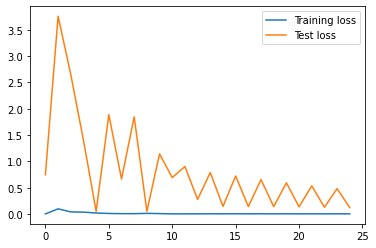

In [724]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [725]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.096510149538517, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09650123864412308, 0.09664365649223328, 0.09658984839916229, 0.09655400365591049, 0.09667379409074783, 0.09788867086172104, 0.09736060351133347, 0.09758076071739197, 0.09714375436306, 0.09729768335819244, 0.09697114676237106, 0.09790576249361038, 0.09975969046354294, 0.1004960909485817, 0.09947981685400009, 0.10210791230201721, 0.1033119261264801, 0.105315200984478, 0.10922759026288986, 0.11188773810863495, 0.11332568526268005, 0.11530810594558716, 0.11786550283432007, 0.1

In [726]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 3258 Actual 3388
Predicted 3763 Actual 3448
Predicted 4334 Actual 4070
Predicted 4960 Actual 4785
Predicted 5625 Actual 6060
Predicted 6282 Actual 4268
Predicted 6896 Actual 5642
Predicted 7438 Actual 5236
Predicted 7891 Actual 4774
Predicted 8254 Actual 5849
Predicted 8534 Actual 5965
Predicted 8745 Actual 6361
Predicted 8901 Actual 6198
Predicted 9016 Actual 6411
Predicted 9100 Actual 5841
Predicted 9160 Actual 7099
Predicted 9204 Actual 7933
Train RMSE =  239.27743108184197
Test RMSE =  2018.4802814646926
RMSE Against Pakistan =  5794.04301842051


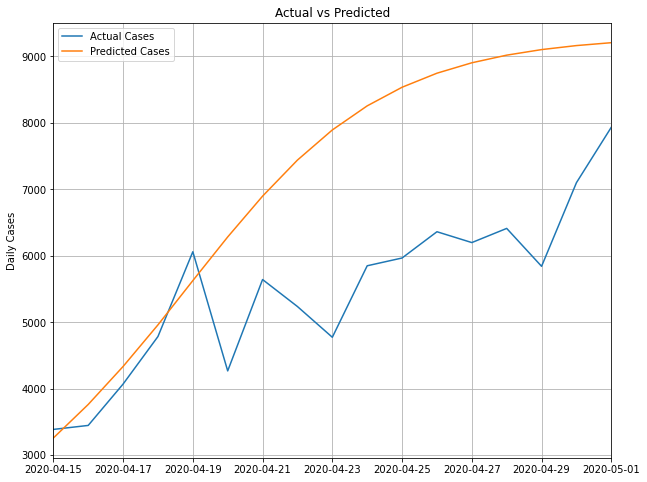

In [727]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

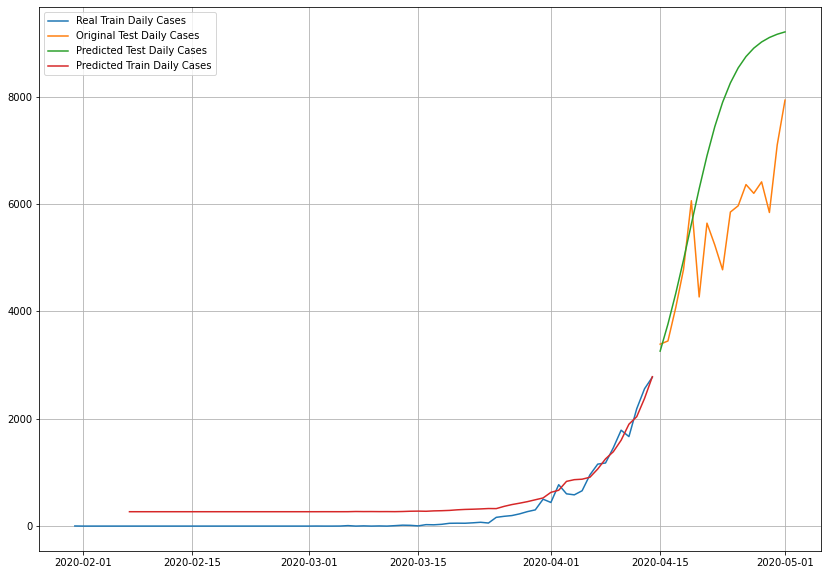

In [728]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

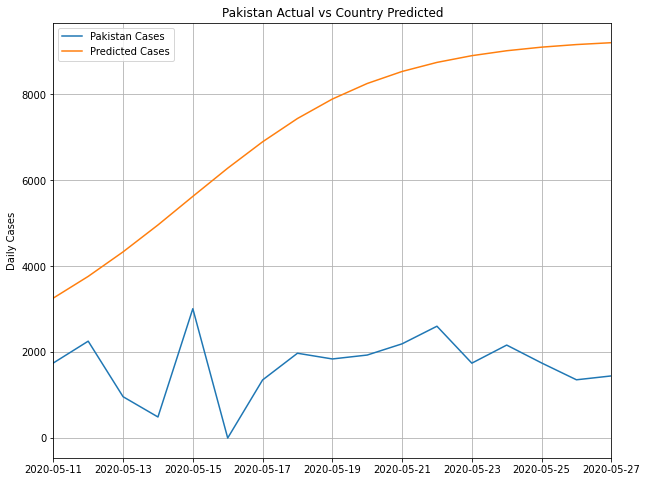

In [729]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [730]:
#CONFIGURATIONS
COUNTRY = "Russia"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

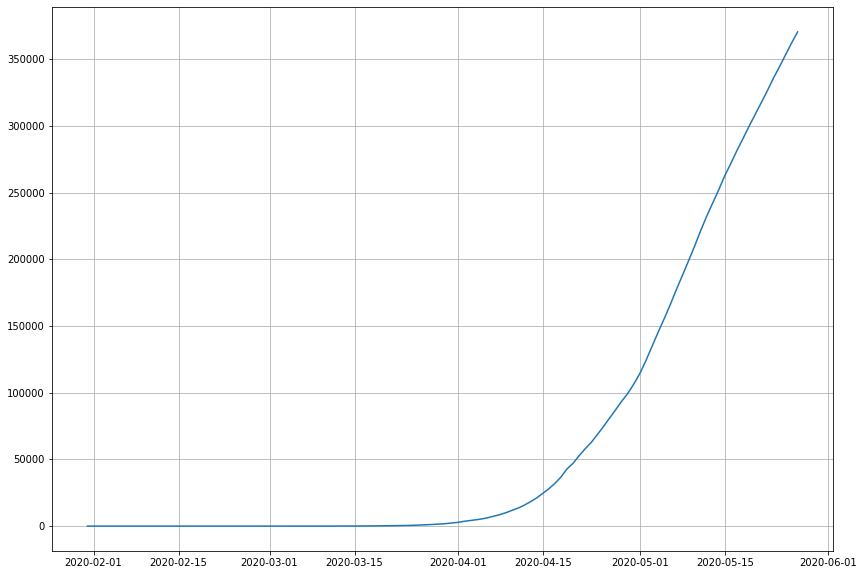

In [731]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

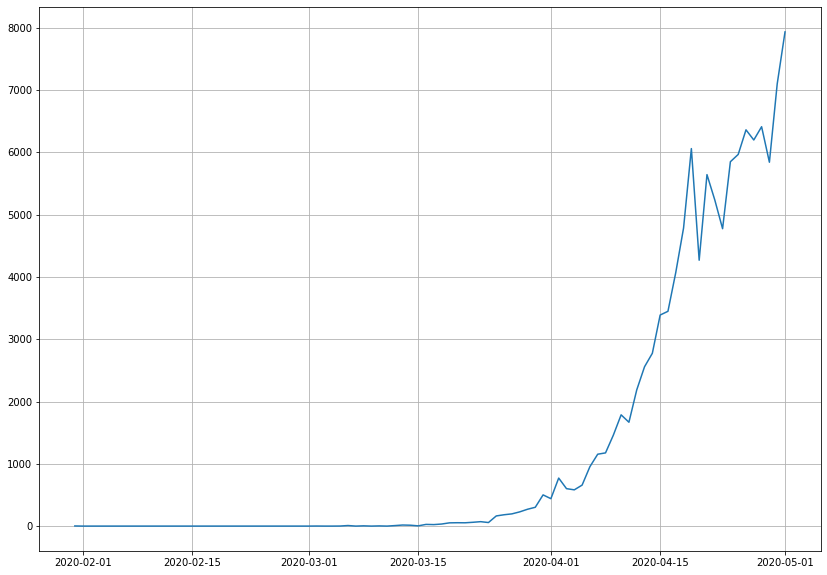

In [732]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

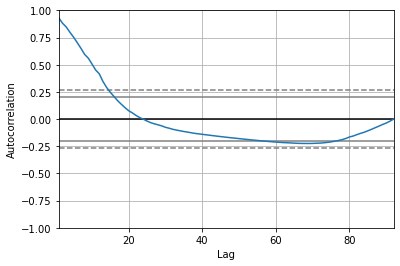

In [733]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Russia, a suitable window size might be around 7, as the values are most correalted for that range

In [734]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [736]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([0.])),

In [737]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,25,train_seq)

Epoch 0 train loss: 0.0026188811771472144
Epoch 5 train loss: 0.009385463586998936
Epoch 10 train loss: 0.0036347917390554918
Epoch 15 train loss: 0.002646857358778066
Epoch 20 train loss: 0.002490777030193314
Epoch 24 train loss: 0.0024618856469237754


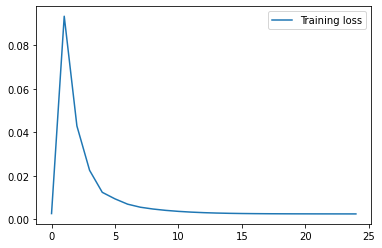

In [738]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [739]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.0101262666285038, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010117392987012863, 0.010160837322473526, 0.010151945054531097, 0.01014212891459465, 0.010177522897720337, 0.010553862899541855, 0.010460082441568375, 0.010534930974245071, 0.010416656732559204, 0.010451596230268478, 0.010355036705732346, 0.010622676461935043, 0.011210452765226364, 0.011561304330825806, 0.011349663138389587, 0.012159045785665512, 0.012666173279285431, 0.013421107083559036, 0.014777328819036484, 0.015859369188547134, 0.01658701151609

In [740]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  416.9795398010007


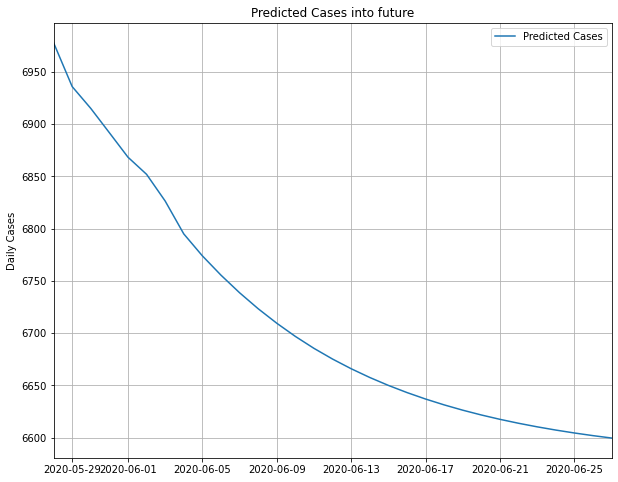

In [741]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

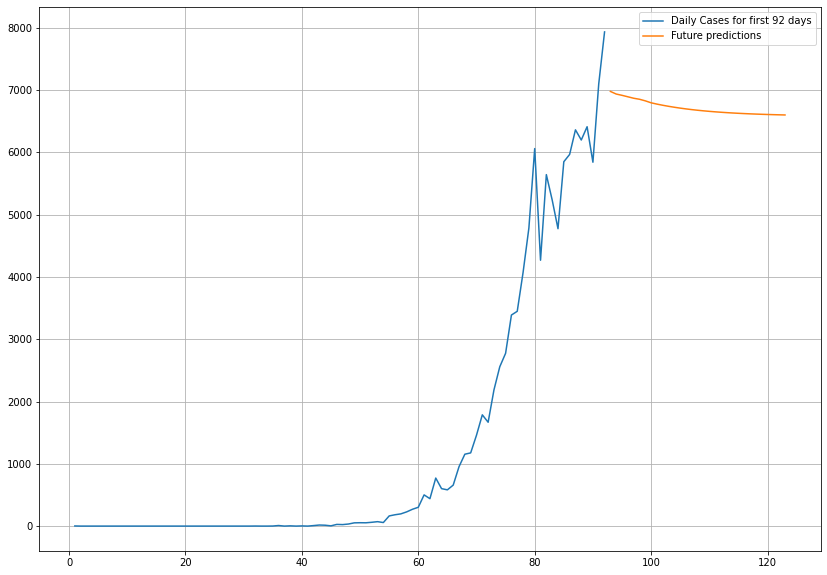

In [742]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Canada


#### Prediction from 10th May to 27th May

In [743]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

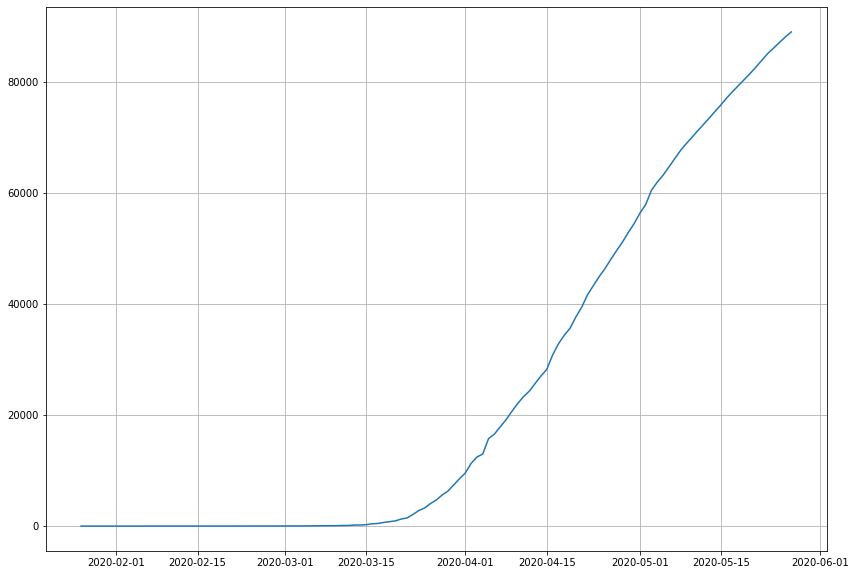

In [744]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

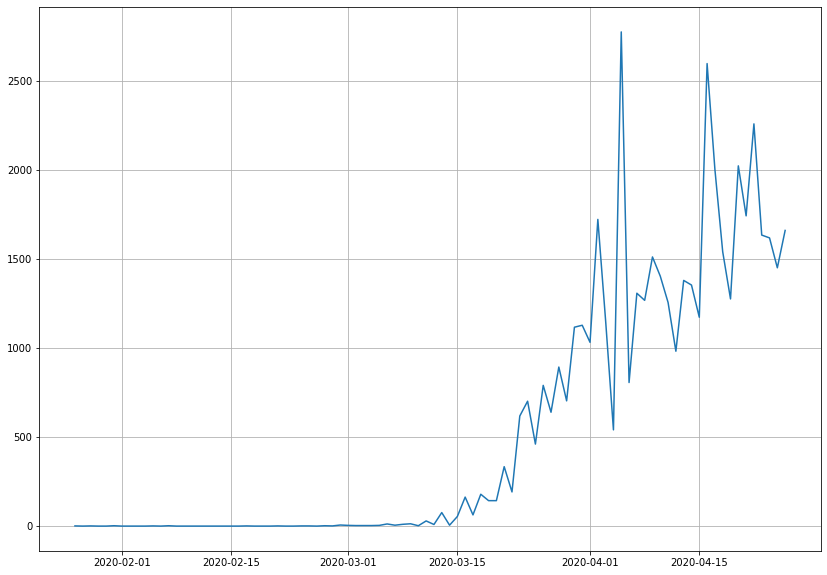

In [745]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

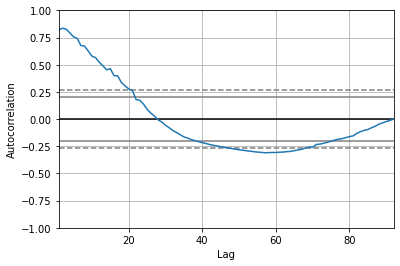

In [746]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 4, as the values are most correalted for that range

In [747]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [749]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.0004])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor

In [750]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,15,train_seq,test_seq)

Epoch 0 train loss: 0.012359004721591807 test loss: 0.014398529717800557
Epoch 5 train loss: 0.017936568651797574 test loss: 0.02637065835879184
Epoch 10 train loss: 0.012060994085216195 test loss: 0.018980598356574774
Epoch 14 train loss: 0.01074399737712263 test loss: 0.015303510571266088


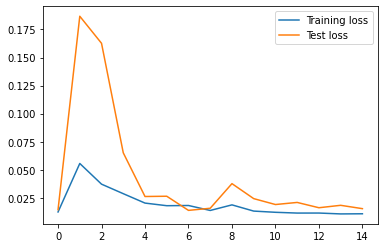

In [751]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [752]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.08076632767915726, 0.0807223692536354, 0.0806703045964241, 0.08062118291854858, 0.08065807819366455, 0.08065544813871384, 0.08076576143503189, 0.08077920228242874, 0.08073797076940536, 0.0806802436709404, 0.08062896877527237, 0.08058999478816986, 0.08057011663913727, 0.0805545374751091, 0.0805545374751091, 0.0805545374751091, 0.08062262833118439, 0.08063987642526627, 0.08062958717346191, 0.08060852438211441, 0.08065594732761383, 0.08065760135650635, 0.0806373804807663, 0.0806766152381897, 0.080741286277771, 0.08073265850543976, 0.08082754164934158, 0.08088061213493347, 0.08124954253435135, 0.08154749870300293, 0.08167898654937744, 0.08170782029628754, 0.08168921619653702, 0.08171746879816055, 0.0823175385594368, 0.0825658068060875, 0.08295538276433945, 0.08352620154619217, 0.08331570029258728, 0.0846249908208847, 0.08501087874174118, 0.08942880481481552, 0.09000930190086365, 0.09195154905319214, 0.10155671834945679, 0.10604837536811829, 0.11485996842384338, 0.12164

In [753]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 1453 Actual 1405
Predicted 1486 Actual 1257
Predicted 1518 Actual 983
Predicted 1542 Actual 1381
Predicted 1575 Actual 1355
Predicted 1599 Actual 1174
Predicted 1621 Actual 2600
Predicted 1642 Actual 2005
Predicted 1662 Actual 1542
Predicted 1681 Actual 1277
Predicted 1698 Actual 2025
Predicted 1714 Actual 1744
Predicted 1728 Actual 2261
Predicted 1741 Actual 1636
Predicted 1754 Actual 1620
Predicted 1765 Actual 1452
Predicted 1775 Actual 1662
Train RMSE =  304.6911049728786
Test RMSE =  375.3230529100808
RMSE Against Pakistan =  706.2432448309127


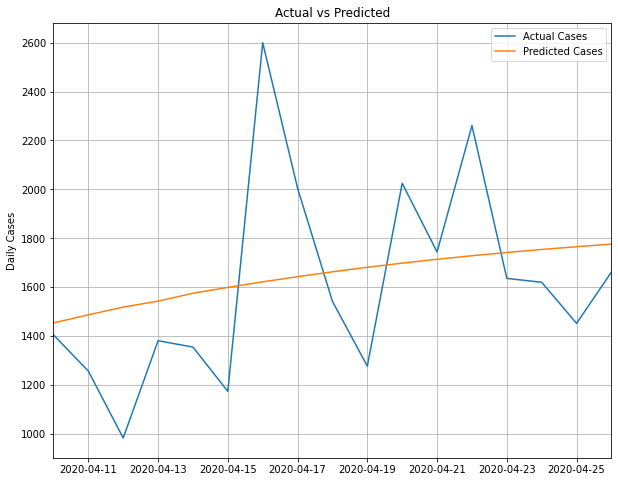

In [754]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

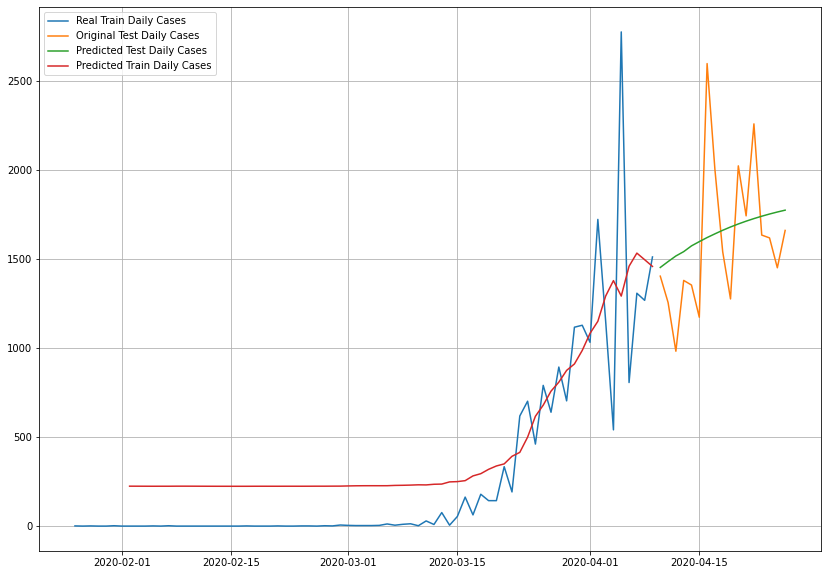

In [755]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

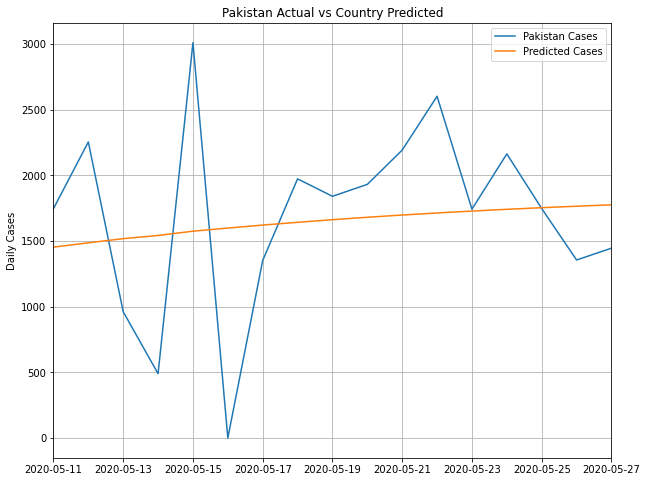

In [756]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series_test,label = "Pakistan Cases")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [757]:
#CONFIGURATIONS
COUNTRY = "Canada"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

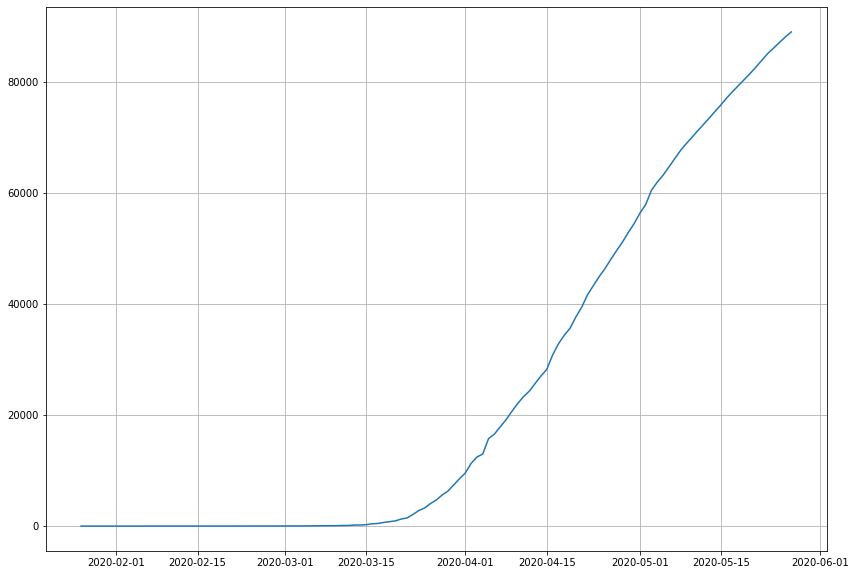

In [758]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

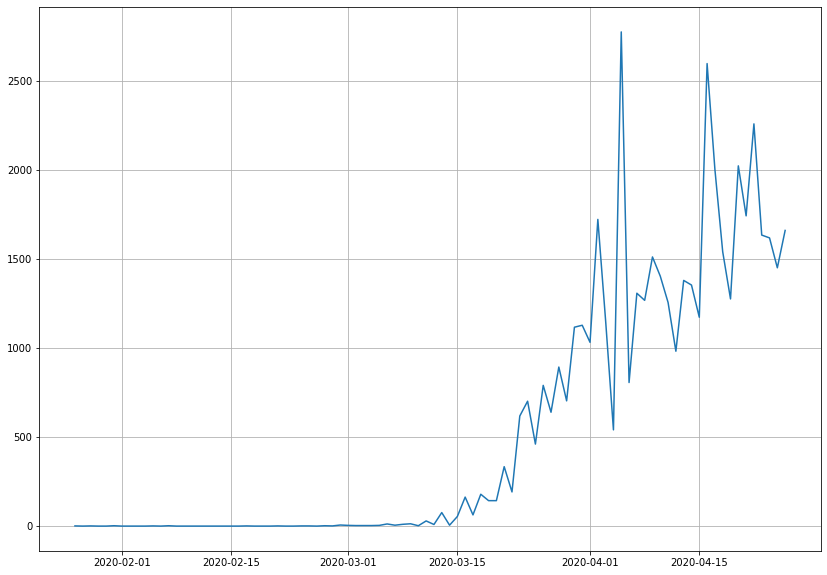

In [759]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

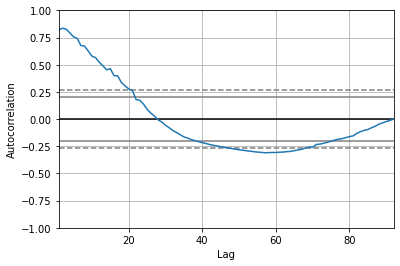

In [760]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Canada, a suitable window size might be around 4, as the values are most correalted for that range

In [761]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 4
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [763]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0004, 0.0000, 0.0004, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0004, 0.0000, 0.0000]), tensor([0.0007])), (tensor([0.0004, 0.0000, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.0004])), (tensor([0.0000, 0.0000, 0.0000, 0.0004]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0004, 0.0000]), tensor([0.0007])), (tensor([0.0000, 0.0004, 0.0000, 0.0007]), tensor([0.])), (tensor([0.0004, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0000]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.])), (tensor([0., 0., 0., 0.]), tensor([0.00

In [764]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,50,train_seq)

Epoch 0 train loss: 0.012758296250489298
Epoch 5 train loss: 0.021072425181242173
Epoch 10 train loss: 0.01415364008770472
Epoch 15 train loss: 0.012203424552922115
Epoch 20 train loss: 0.011385343998125796
Epoch 25 train loss: 0.011085535700500143
Epoch 30 train loss: 0.010901290934479235
Epoch 35 train loss: 0.010771961597070218
Epoch 40 train loss: 0.010680523375055208
Epoch 45 train loss: 0.010606760777005064
Epoch 49 train loss: 0.010549597371212903


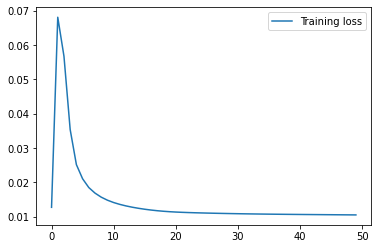

In [765]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [766]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.017645888030529022, -0.01778492145240307, -0.017792612314224243, -0.01766805350780487, -0.01753147877752781, -0.017623761668801308, -0.018038393929600716, -0.01801914907991886, -0.017853206023573875, -0.017746465280652046, -0.017460739240050316, -0.01753147877752781, -0.017623761668801308, -0.018038393929600716, -0.018038393929600716, -0.018038393929600716, -0.018038393929600716, -0.018038393929600716, -0.018038393929600716, -0.01801914907991886, -0.017853206023573875, -0.01778492145240307, -0.01783105731010437, -0.01801914907991886, -0.017853206023573875, -0.01778492145240307, -0.017811836674809456, -0.017833970487117767, -0.01759975776076317, -0.017539212480187416, -0.01744152046740055, -0.017231011763215065, -0.016183197498321533, -0.015513626858592033, -0.015170270577073097, -0.01583707146346569, -0.016024891287088394, -0.015686562284827232, -0.014088807627558708, -0.01305806078016758, -0.012195102870464325, -0.012031538411974907, -0.01176282949745655, -0.0093

In [767]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  273.66415103108284


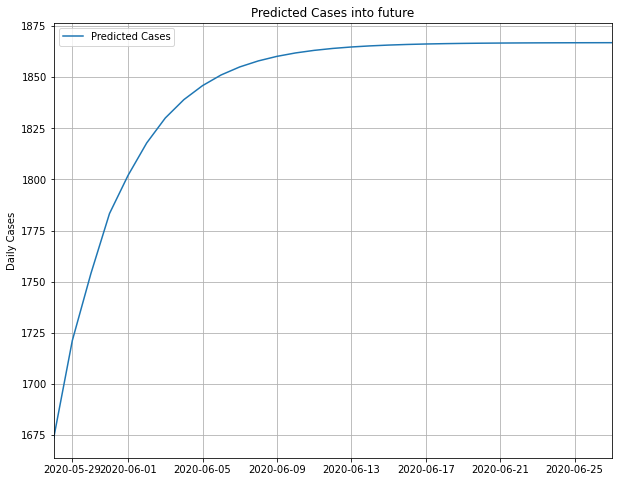

In [768]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

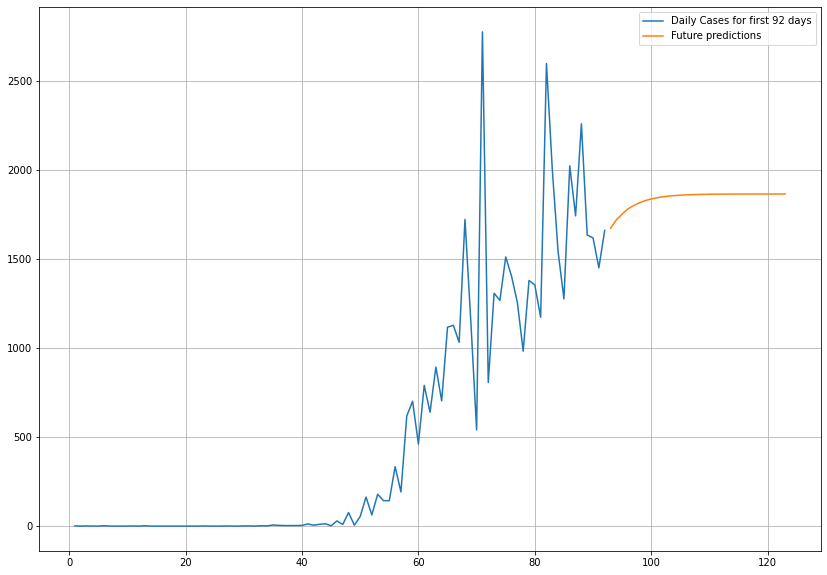

In [769]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

### Pakistan


#### Prediction from 10th May to 27th May

In [788]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

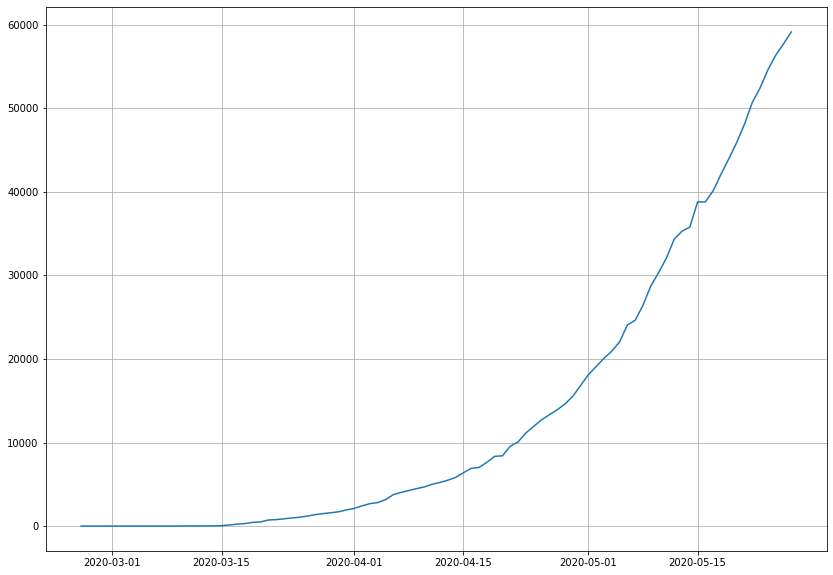

In [789]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

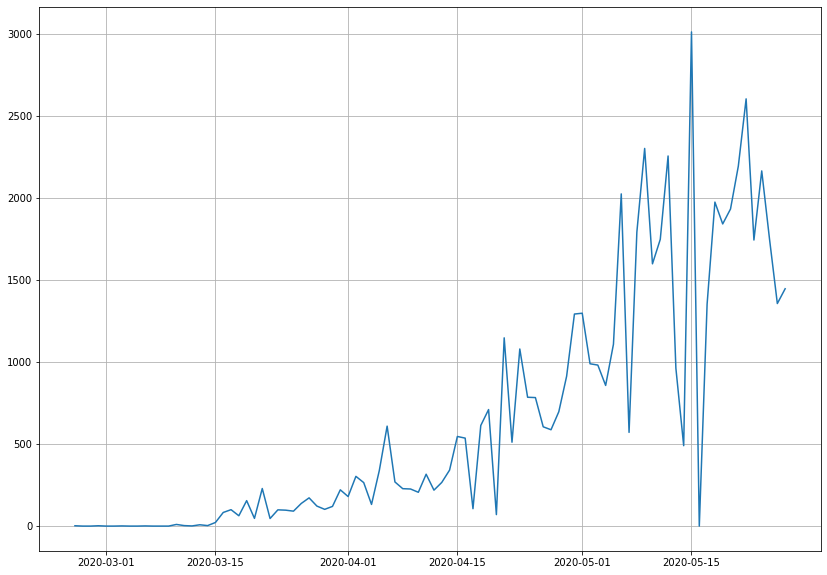

In [790]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

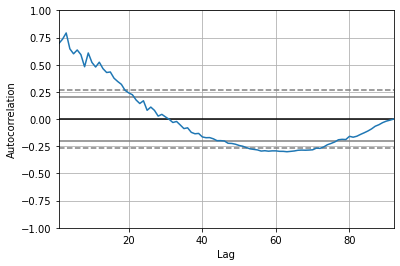

In [791]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 10, as the values are most correalted for that range

In [792]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 7
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(75,)
(17,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(daily_cases.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [794]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor

In [795]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,24,train_seq,test_seq)

Epoch 0 train loss: 0.007902678418290902 test loss: 0.021702999947592616
Epoch 5 train loss: 0.01405094967527685 test loss: 0.16085055676521734
Epoch 10 train loss: 0.007988477035332805 test loss: 0.15160176104764106
Epoch 15 train loss: 0.007806067868620951 test loss: 0.11562796730795526
Epoch 20 train loss: 0.0076895719593574755 test loss: 0.10103558162008994
Epoch 23 train loss: 0.007651905241515234 test loss: 0.09717075964954347


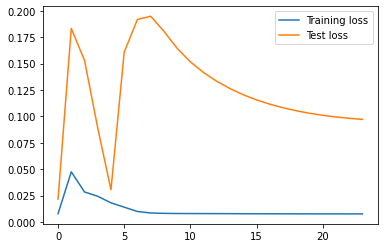

In [796]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [797]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.02729591727256775, 0.02724100649356842, 0.027226455509662628, 0.02725665271282196, 0.027208037674427032, 0.027198627591133118, 0.027187936007976532, 0.027606956660747528, 0.027789562940597534, 0.027803882956504822, 0.028065204620361328, 0.028155386447906494, 0.02904941886663437, 0.03277851641178131, 0.03733164444565773, 0.040121033787727356, 0.04636228084564209, 0.04766387492418289, 0.05618023872375488, 0.05671662837266922, 0.05648595094680786, 0.05590595677495003, 0.0560457743704319, 0.05616602301597595, 0.06094273179769516, 0.05917374789714813, 0.06041625887155533, 0.06065864861011505, 0.06570017337799072, 0.0697195753455162, 0.07770088315010071, 0.08361915498971939, 0.08369460701942444, 0.09208348393440247, 0.11421025544404984, 0.11960592120885849, 0.12000604718923569, 0.11483901739120483, 0.1098175048828125, 0.11415502429008484, 0.1088801920413971, 0.09819076955318451, 0.10225647687911987, 0.11793120205402374, 0.13488079607486725, 0.13073357939720154, 0.1419305

In [798]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions[x][0]),"Actual",int(real_values[x][0]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values,actual_predictions))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions))
print("RMSE Against Pakistan = ",pak_rms)

train_rmse[COUNTRY] = train_rms
test_rmse[COUNTRY] = test_rms
pak_rmse[COUNTRY] = pak_rms
pred_trend[COUNTRY] = actual_predictions

Test cases prediction
Predicted 4374 Actual 1747
Predicted 6807 Actual 2255
Predicted 7224 Actual 961
Predicted 7372 Actual 490
Predicted 7473 Actual 3011
Predicted 7533 Actual 0
Predicted 7569 Actual 1352
Predicted 7594 Actual 1974
Predicted 7605 Actual 1841
Predicted 7609 Actual 1932
Predicted 7610 Actual 2193
Predicted 7611 Actual 2603
Predicted 7612 Actual 1743
Predicted 7612 Actual 2164
Predicted 7612 Actual 1748
Predicted 7612 Actual 1356
Predicted 7612 Actual 1446
Train RMSE =  253.93017552056455
Test RMSE =  5722.735853971568
RMSE Against Pakistan =  5722.735859434693


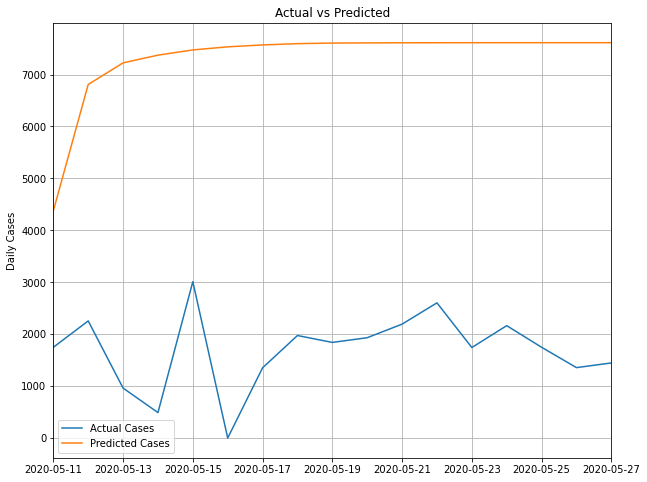

In [799]:
plt.figure(figsize=(10,8))
plt.title('Actual vs Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
plt.plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
plt.legend();

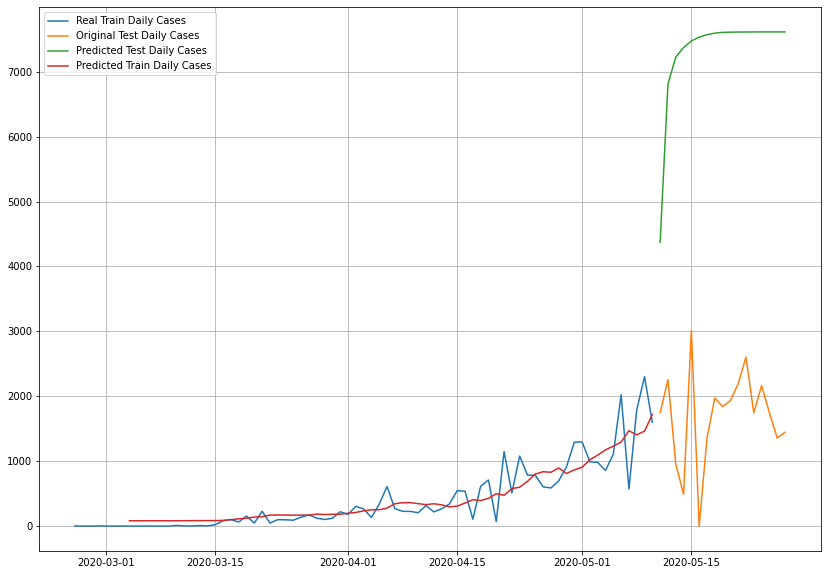

In [800]:
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  daily_cases.index[:len(train_data)],
  train_data.values,
  label='Real Train Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
plt.plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
plt.legend();

#### Prediction from 27th May to 27th June

Since this is for predictions beyond 27th May, we will now be training our model on first 92 days of a country's data

In [801]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 31  #because we have 31 days between 27th May and 27th June
MAX_DAYS_TO_TRAIN = 92 #because we have 92 days between 28th Feb and 27th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

4/27/20     587.0
4/28/20     697.0
4/29/20     913.0
4/30/20    1292.0
5/1/20     1297.0
5/2/20      989.0
5/3/20      981.0
5/4/20      857.0
5/5/20     1108.0
5/6/20     2024.0
5/7/20      571.0
5/8/20     1791.0
5/9/20     2301.0
5/10/20    1598.0
5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

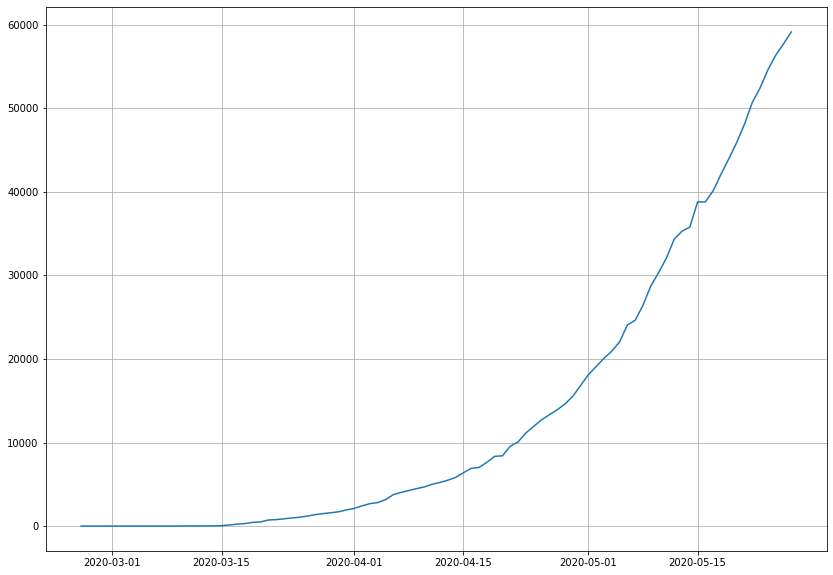

In [802]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

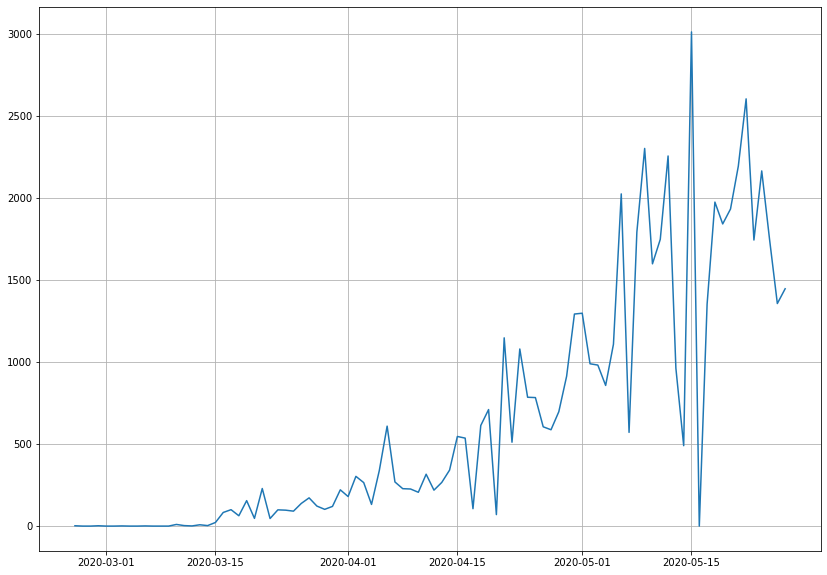

In [803]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

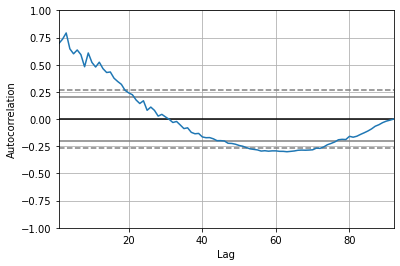

In [804]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 5, as the values are most correalted for that range

In [805]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
WINDOW_SIZE = 5
train_data = daily_cases
print(train_data.shape)

(92,)


In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data_normalized = scaler.transform(train_data.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [807]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0007, 0.0000, 0.0000, 0.0007, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0007, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0007, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0007, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.0003])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0003]), tensor([0.])), (tensor([0.0003, 0.0000, 0.0000, 0.0003, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0000, 0.0003, 0.0000, 0.0000]), tensor([0.])), (tensor([0.0000, 0.0003, 0.0000, 0.0000, 0.0000]), tensor([0.0033])), (tensor([0.0003, 0.0000, 0.0000, 0.0000, 0.0033]), tensor([0.0010])), (tensor([0.0000, 0.0000, 0.0000, 0.0033, 0.0010]), tensor([0.0003])), (tensor([0.0000, 0.0000, 0.0033, 0.0010, 0.0003]), tensor([0.0027])), (tensor([0.0000, 0.0033, 0.0010, 0.0003, 0.0027]), tensor([0.0010])), (tensor([0.0033, 0.0010, 0.0003, 0.0027, 0.0010]), tensor([0.0073])), (tensor([0.0010, 0.0003, 0.0027, 0.0010, 0.

In [808]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,20,train_seq)

Epoch 0 train loss: 0.020422116939958795
Epoch 5 train loss: 0.02942392018321406
Epoch 10 train loss: 0.01965140500605104
Epoch 15 train loss: 0.016144151145319495
Epoch 19 train loss: 0.015046474650716846


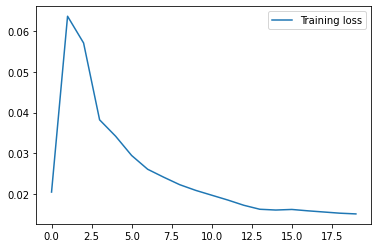

In [809]:
plt.plot(train_hist, label="Training loss")
plt.legend();

In [810]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 31
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [-0.08088799566030502, -0.08107820898294449, -0.08102037757635117, -0.08098458498716354, -0.08120720833539963, -0.08115916699171066, -0.08111210912466049, -0.08120720833539963, -0.08119740337133408, -0.08082621544599533, -0.08025508373975754, -0.07971661537885666, -0.07915749400854111, -0.07862720638513565, -0.07865085452795029, -0.07440456002950668, -0.06511186808347702, -0.054718874394893646, -0.04155518859624863, -0.03094496577978134, -0.02592337876558304, -0.02008727937936783, -0.01586148887872696, -0.023148857057094574, -0.01970907300710678, -0.03438206762075424, -0.02264208346605301, -0.015553422272205353, -0.010677792131900787, -0.008216656744480133, -0.008460275828838348, -0.005980871617794037, 0.008445687592029572, 0.03187551349401474, 0.04794871062040329, 0.04770324379205704, 0.0695304349064827, 0.09639900922775269, 0.11329293996095657, 0.12080163508653641, 0.09271948039531708, 0.049191638827323914, 0.04996006190776825, 0.053803451359272, 0.06114045903086662

In [811]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))
train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred))
print("Train RMSE = ",train_rms)
pred_trend_fut[COUNTRY] = actual_predictions

Train RMSE =  381.1888612570274


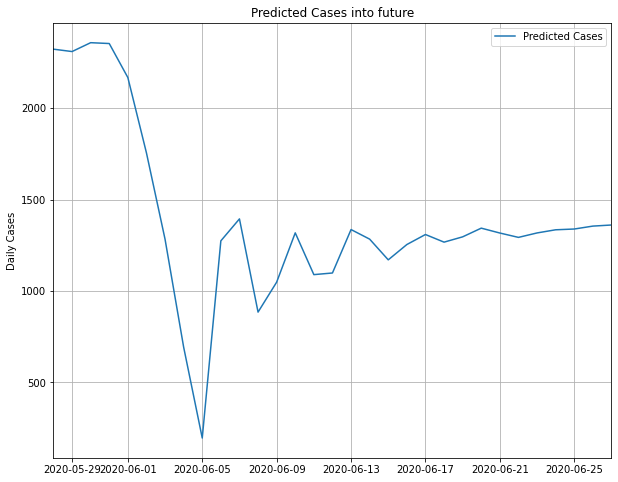

In [812]:
plt.figure(figsize=(10,8))
plt.title('Predicted Cases into future')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
plt.plot(index,actual_predictions, label = "Predicted Cases")
plt.legend();

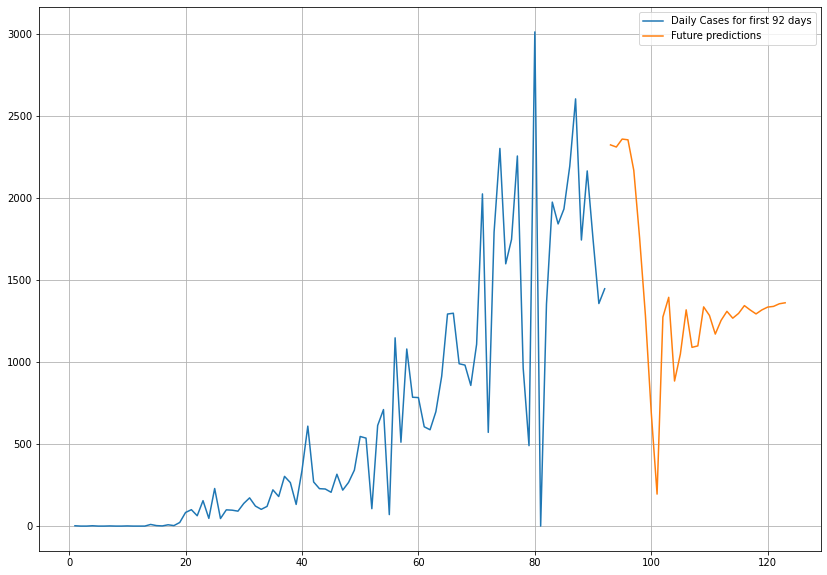

In [813]:
index = [x for x in range(1,124)]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(
  index[:92],
  train_data.values,
  label='Daily Cases for first 92 days'
)
plt.plot(
  index[92:],
  actual_predictions,
  label='Future predictions'
)
plt.legend();

## Approach 2 (LSTM, trained on stationary series)

In [1048]:
#CONFIGURATIONS
COUNTRY = "Pakistan"
DAYS_TO_PREDICT = 17 #because we have 17 days between 10th May and 27th May
MAX_DAYS_TO_TRAIN = 75 #because we have 75 days between 28th Feb and 10th May
MAX_DAYS_UNDER_OBSERVATION = 92 #because Pakistan series uptil 27th May is of 92 days
pak_series_test = getTimeSeriesTillDate("Pakistan",dataset,"5/27/20")
pak_series_test = pak_series_test[-DAYS_TO_PREDICT-1:] #-1 to calculate daily cases for 11th may as well
pak_series_test = pak_series_test - pak_series_test.shift()
pak_series_test = pak_series_test[1:]
pak_series_test

5/11/20    1747.0
5/12/20    2255.0
5/13/20     962.0
5/14/20     490.0
5/15/20    3011.0
5/16/20       0.0
5/17/20    1352.0
5/18/20    1974.0
5/19/20    1841.0
5/20/20    1932.0
5/21/20    2193.0
5/22/20    2603.0
5/23/20    1743.0
5/24/20    2164.0
5/25/20    1748.0
5/26/20    1356.0
5/27/20    1446.0
dtype: float64

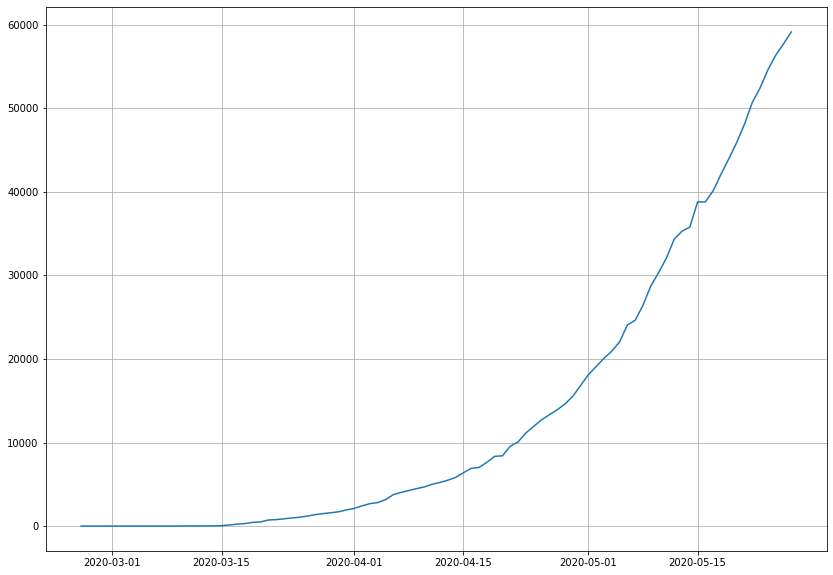

In [1049]:
cumm_cases = getTimeSeriesTillDate(COUNTRY,dataset,'5/27/20')
cumm_cases.index = pd.to_datetime(cumm_cases.index)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(cumm_cases)

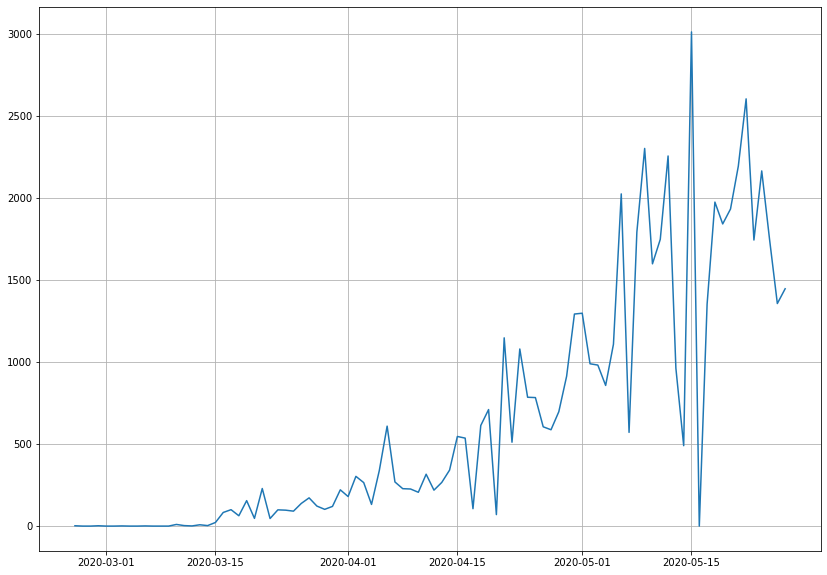

In [1050]:
daily_cases = cumm_cases - cumm_cases.shift()
daily_cases.fillna(cumm_cases[0],inplace = True) #first element will always be a Nan and we fill it with the cummulative number of cases registered on first day,which actually are the daily cases on first day as well
daily_cases = daily_cases[:MAX_DAYS_UNDER_OBSERVATION]
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases)

In [0]:
def makeSeriesStationary(series):
    abc = series - series.shift()
    abc.fillna(0,inplace = True)
    return abc
def reverseStationarySeries(series,start,index):
    abc = pd.Series(series, copy=True)
    abc_cumsum = abc.cumsum()
    temp = pd.Series(start,index)
    temp = temp.add(abc_cumsum,fill_value=0)
    return temp

def reverseStationarySeries3(series,start):
    abc = pd.Series(series)
    for x in range(1,len(abc)):
      abc[x] = abc[x] + abc[x-1]
    for x in range(len(abc)):
      abc[x] = abc[x] + start
    abc = pd.Series(abc)
    return abc

def compare(sr1, sr2):
  diff = 0
  for x,y in enumerate(sr1):
    diff += abs(y) - abs(sr2[x])
  return diff

2020-02-26       2.0
2020-02-27       0.0
2020-02-28       0.0
2020-02-29       2.0
2020-03-01       0.0
               ...  
2020-05-23    1743.0
2020-05-24    2164.0
2020-05-25    1748.0
2020-05-26    1356.0
2020-05-27    1446.0
Length: 92, dtype: float64
2020-02-26      0.0
2020-02-27     -2.0
2020-02-28      0.0
2020-02-29      2.0
2020-03-01     -2.0
              ...  
2020-05-23   -860.0
2020-05-24    421.0
2020-05-25   -416.0
2020-05-26   -392.0
2020-05-27     90.0
Length: 92, dtype: float64


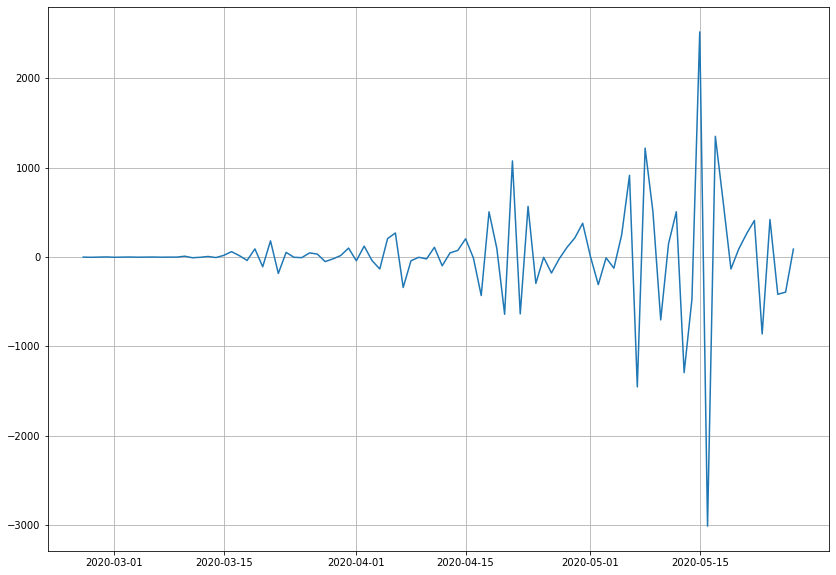

In [1052]:
print(daily_cases)
daily_cases2 = makeSeriesStationary(daily_cases)
print(daily_cases2)
daily_cases3 = reverseStationarySeries(daily_cases2,daily_cases[0],daily_cases.index)
# print(daily_cases3)
plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(daily_cases2)

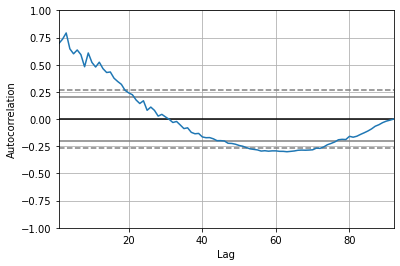

In [1053]:
autocorrelation_plot(daily_cases)
plt.show()

The auto-correlation plot above shows that for Pakistan, a suitable window size might be around 6, as the values are most correalted for that range

In [1054]:
# we have total of 17 days from 10th may to 27th May (we want to predict from 10th May to 27th May), and i am using those as test data in this case
# daily_cases = makeSeriesStationary(daily_cases)
WINDOW_SIZE = 6
test_data_size = DAYS_TO_PREDICT
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data_stat = makeSeriesStationary(train_data)
test_data_stat = makeSeriesStationary(test_data)
print(train_data.shape)
print(test_data.shape)


(75,)
(17,)


In [0]:
scaler = MinMaxScaler((-1,1))
train_data_normalized = scaler.fit_transform(train_data_stat.values.reshape(-1,1))
test_data_normalized = scaler.fit_transform(test_data_stat.values.reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [1056]:
train_seq = create_sequences(train_data_normalized, WINDOW_SIZE)
test_seq = create_sequences(test_data_normalized, WINDOW_SIZE)
print(train_seq)

[(tensor([0.0872, 0.0857, 0.0872, 0.0887, 0.0857, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0887, 0.0857, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0887, 0.0857, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0887, 0.0857, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0879])), (tensor([0.0857, 0.0872, 0.0879, 0.0864, 0.0872, 0.0879]), tensor([0.0864])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0879, 0.0864]), tensor([0.0872])), (tensor([0.0879, 0.0864, 0.0872, 0.0879, 0.0864, 0.0872]), tensor([0.0872])), (tensor([0.0864, 0.0872, 0.0879, 0.0864, 0.0872, 0.0872]), tensor([0.0947])), (tensor([0.0872, 0.0879, 0.0864, 0.0872, 0.0872, 0.0947]), tensor([0.0819])), (tensor([0.0879, 0.0864, 0.0872, 0.0872, 0.0947, 0.0819]), tensor([0.0857])), (tensor([0.0864, 0.0872, 0.0872, 0.0947, 0.0819, 0.0857]), tensor([0.0924])), (tensor([0.0872, 0.0872, 0.0947, 0.0819, 0.0857, 0.0924]), tensor([0.0834])), (tensor([0.0872, 0.0947, 0.0819, 0.0857, 0.0924, 0.0834]), tens

In [1057]:
model = LSTM()
model,train_hist,test_hist = train_LSTM_model(model,100,train_seq,test_seq)

Epoch 0 train loss: 0.07305728715884496 test loss: 0.040205292040396176
Epoch 5 train loss: 0.05345918548561282 test loss: 0.0268580229428401
Epoch 10 train loss: 0.03798929383973512 test loss: 0.037790307327999144
Epoch 15 train loss: 0.03310023329442194 test loss: 0.060854322769128805
Epoch 20 train loss: 0.03102036639393191 test loss: 0.09159532032737677
Epoch 25 train loss: 0.02953541133907176 test loss: 0.12469917044720867
Epoch 30 train loss: 0.027975190634456883 test loss: 0.16646807539192113
Epoch 35 train loss: 0.026560400649585696 test loss: 0.20903008727526123
Epoch 40 train loss: 0.024646920743957773 test loss: 0.26207811901853845
Epoch 45 train loss: 0.02323041895844021 test loss: 0.29795068079097703
Epoch 50 train loss: 0.021616301739426937 test loss: 0.3007998683235862
Epoch 55 train loss: 0.018581867930547363 test loss: 0.2666167902167548
Epoch 60 train loss: 0.016883064229521395 test loss: 0.21156298218623057
Epoch 65 train loss: 0.015363692891100256 test loss: 0.14722

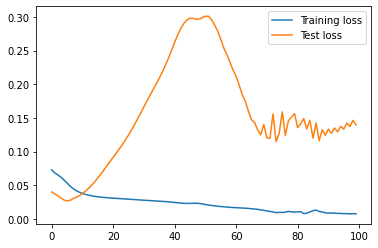

In [1058]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [1076]:
train_pred_temp = []
for seq, labels in train_seq:
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
      train_pred_temp.append(float(model(seq)))
print("Train Predictions",train_pred_temp)

future_pred = 17
test_inputs = train_data_normalized[-WINDOW_SIZE:].tolist()
model.eval()
for i in range(future_pred):
    seq = torch.FloatTensor(test_inputs[-WINDOW_SIZE:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
print("Test Predictions",test_inputs[WINDOW_SIZE:])

Train Predictions [0.15863601863384247, 0.15720602869987488, 0.15757565200328827, 0.15874172747135162, 0.15707160532474518, 0.15760302543640137, 0.15844687819480896, 0.15768775343894958, 0.1539827585220337, 0.15536712110042572, 0.16015930473804474, 0.15712441504001617, 0.15578964352607727, 0.15497830510139465, 0.12339936196804047, 0.1155848354101181, 0.14814187586307526, 0.13077197968959808, 0.1559808999300003, 0.14640018343925476, 0.15646110475063324, 0.16462354362010956, 0.1568646878004074, 0.14260177314281464, 0.16351251304149628, 0.10917674005031586, 0.1535930335521698, 0.17577847838401794, 0.1673349291086197, 0.12470600008964539, 0.12591193616390228, 0.09653018414974213, 0.11731076240539551, 0.17966416478157043, 0.18071512877941132, -0.11983683705329895, 0.1546664983034134, 0.14224392175674438, 0.10524144768714905, 0.2268025428056717, -0.012068994343280792, 0.2823008894920349, 0.15195181965827942, 0.11755959689617157, 0.017374683171510696, 0.052753884345293045, 0.2715352773666382,

In [0]:
train_pred = scaler.inverse_transform(np.array(train_pred_temp).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(test_inputs[WINDOW_SIZE:] ).reshape(-1, 1))
real_values = scaler.inverse_transform(np.array(test_data_normalized).reshape(-1, 1))

In [1078]:
train_idx = daily_cases.index[WINDOW_SIZE:len(train_pred)+WINDOW_SIZE]
train_pred2 = reverseStationarySeries3(train_pred.flatten(),train_data[WINDOW_SIZE])
print(train_pred2)

0      194.787228
1      384.619103
2      575.473356
3      769.552975
4      959.013035
         ...     
64    9266.538056
65    6210.160874
66    8768.539066
67    9683.761135
68    8353.571682
Length: 69, dtype: float64


In [1079]:
test_idx = daily_cases.index[len(train_data):]
actual_predictions2 = reverseStationarySeries3(actual_predictions.flatten(),test_data[0])
print(actual_predictions2)

0     3165.850488
1     1595.793460
2     3162.261738
3     2457.502221
4     3016.684069
5     2550.585962
6     2593.414917
7     2532.200119
8     1868.985916
9     3310.826371
10    1885.014955
11    2956.683330
12    3510.405791
13    2672.721628
14    3337.631422
15    2357.538260
16    3238.093532
dtype: float64


In [1080]:
real_values2 = reverseStationarySeries3(real_values.flatten(),test_data[0])
print(real_values2)
print(compare(real_values2,test_data))

0     1747.000000
1     2255.000000
2      961.999878
3      489.999878
4     3011.000000
5       -0.000122
6     1351.999756
7     1973.999756
8     1840.999756
9     1931.999756
10    2192.999756
11    2602.999756
12    1742.999756
13    2163.999756
14    1747.999756
15    1355.999756
16    1445.999756
dtype: float32
-0.0028076171875


In [1083]:
print("Test cases prediction")
for x in  range(len(actual_predictions)):
  print ("Predicted",int(actual_predictions2[x]),"Actual",int(real_values2[x]))

train_rms = sqrt(mean_squared_error(train_data[WINDOW_SIZE:],train_pred2))
print("Train RMSE = ",train_rms)
test_rms = sqrt(mean_squared_error(real_values2,actual_predictions2))
print("Test RMSE = ",test_rms)
pak_rms = sqrt(mean_squared_error(pak_series_test,actual_predictions2))
print("RMSE Against Pakistan = ",pak_rms)

Test cases prediction
Predicted 3165 Actual 1747
Predicted 1595 Actual 2255
Predicted 3162 Actual 961
Predicted 2457 Actual 489
Predicted 3016 Actual 3011
Predicted 2550 Actual 0
Predicted 2593 Actual 1351
Predicted 2532 Actual 1973
Predicted 1868 Actual 1840
Predicted 3310 Actual 1931
Predicted 1885 Actual 2192
Predicted 2956 Actual 2602
Predicted 3510 Actual 1742
Predicted 2672 Actual 2163
Predicted 3337 Actual 1747
Predicted 2357 Actual 1355
Predicted 3238 Actual 1445
Train RMSE =  4953.044698219963
Test RMSE =  1366.9233753464976
RMSE Against Pakistan =  1366.9232359215232


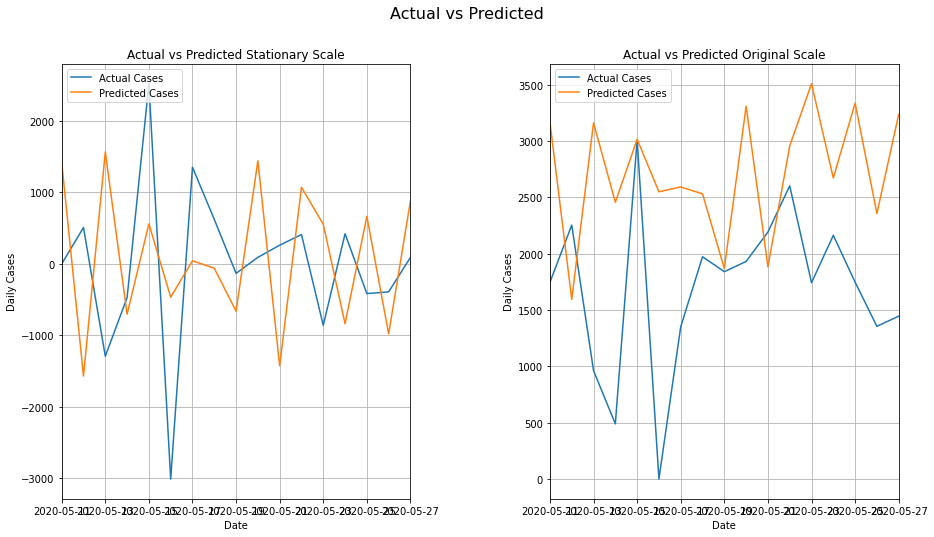

In [1089]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].set_title('Actual vs Predicted Stationary Scale')
axs[0].grid(True)
axs[0].autoscale(axis='x', tight=True)
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values,label = "Actual Cases")
axs[0].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions, label = "Predicted Cases")
axs[0].legend(loc='upper left')
axs[1].grid(True)
axs[1].autoscale(axis='x', tight=True)
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],real_values2,label = "Actual Cases")
axs[1].plot(daily_cases.index[len(train_data):len(train_data) + len(real_values)],actual_predictions2, label = "Predicted Cases")
axs[1].set_title('Actual vs Predicted Original Scale')
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

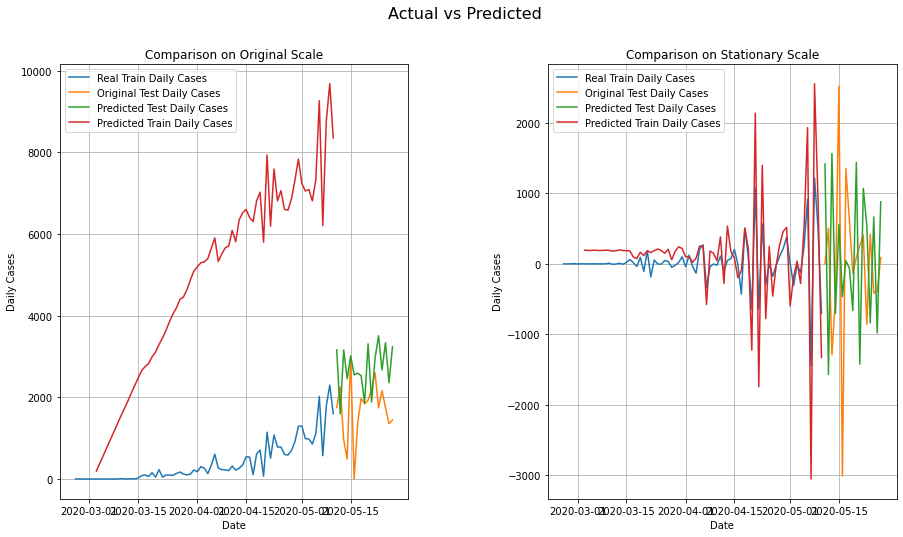

In [1094]:
fig,axs = plt.subplots(1,2,figsize=(15,8))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle("Actual vs Predicted", fontsize=16)
axs[0].grid(True)
axs[0].plot(
  daily_cases.index[:len(train_data)],
  # train_data_stat.values,
  train_data,
  label='Real Train Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values2,
  label='Original Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions2,
  label='Predicted Test Daily Cases'
)
axs[0].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred2,
  label='Predicted Train Daily Cases'
)
axs[0].set_title("Comparison on Original Scale")
axs[0].legend(loc='upper left')

axs[1].grid(True)
axs[1].plot(
  daily_cases.index[:len(train_data)],
  train_data_stat.values,
  label='Real Train Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  real_values,
  label='Original Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[len(train_data):len(train_data) + len(real_values)],
  actual_predictions,
  label='Predicted Test Daily Cases'
)
axs[1].plot(
  daily_cases.index[WINDOW_SIZE:len(train_data)],
  train_pred,
  label='Predicted Train Daily Cases'
)
axs[1].set_title("Comparison on Stationary Scale")
axs[1].legend(loc='upper left')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Daily Cases')

This approach is definitely a better approach capable of giving extremely accurate results, however i was unable to solve a critical problem after continuous struggle.   
The problem lies in casting the predictions back to the non-stationary scale. My technique for scaling to stationary scale and back is bug free, as far as i can think about it.   
The predicted and actual lines look much alike, however it can be seen in the graph above that test predictions though similar in shape to actual cases, are on an incline.  
I suspect the problem lies somewhere between scaling the stationary values back -1 and 1 scale post training.  
This is the approach i was going for in this project originally, but due to this very problem, i could not justify my rmse, and i could not be certain of their legitmacy. There are a few script i found online, which might be helpful, but they have not been utlizied in order to avoid any plagirism
The code and graphs have been left, just for exhibition purposes only. :-)


# Results for Approach 1

## Train RMSE

Following rmse are what were reported during training phase of model, for predictions between 10th May and 27th May

In [814]:
for country in train_rmse.keys():
  print(country,train_rmse[country])

Belgium 343.97605611511824
Sweden 77.57641342871146
India 153.52191988814758
Russia 239.27743108184197
Canada 304.6911049728786
Pakistan 253.93017552056455


## Test RMSE

Following rmse are what were reported during testing phase of model, for predictions between 10th May and 27th May

In [815]:
for country in test_rmse.keys():
  print(country,test_rmse[country])

Belgium 1615.2229892473442
Sweden 158.6883755421491
India 387.4113700084801
Russia 2018.4802814646926
Canada 375.3230529100808
Pakistan 5722.735853971568


## Pakistan RMSE

Following rmse are computed by comparing predictions between 10th May and 27th May with Pakistan

In [816]:
for country in pak_rmse.keys():
  print(country,pak_rmse[country])

Belgium 933.9438323195014
Sweden 1258.3359014339262
India 876.8017813415294
Russia 5794.04301842051
Canada 706.2432448309127
Pakistan 5722.735859434693


We can see than except for Russia and Sweden, we get quite reasonable results  
The reason these two countries were not able to give good results is because of their scale of cases is different than Pakistan.However their performance is good against their own cases. These two countires can be classified as bad picks for predicting cases for pakistan. But they were not discarded, so as to stay consistent with the criteria of picking countries

## Prediction Comaprison (10th May to 27th May)

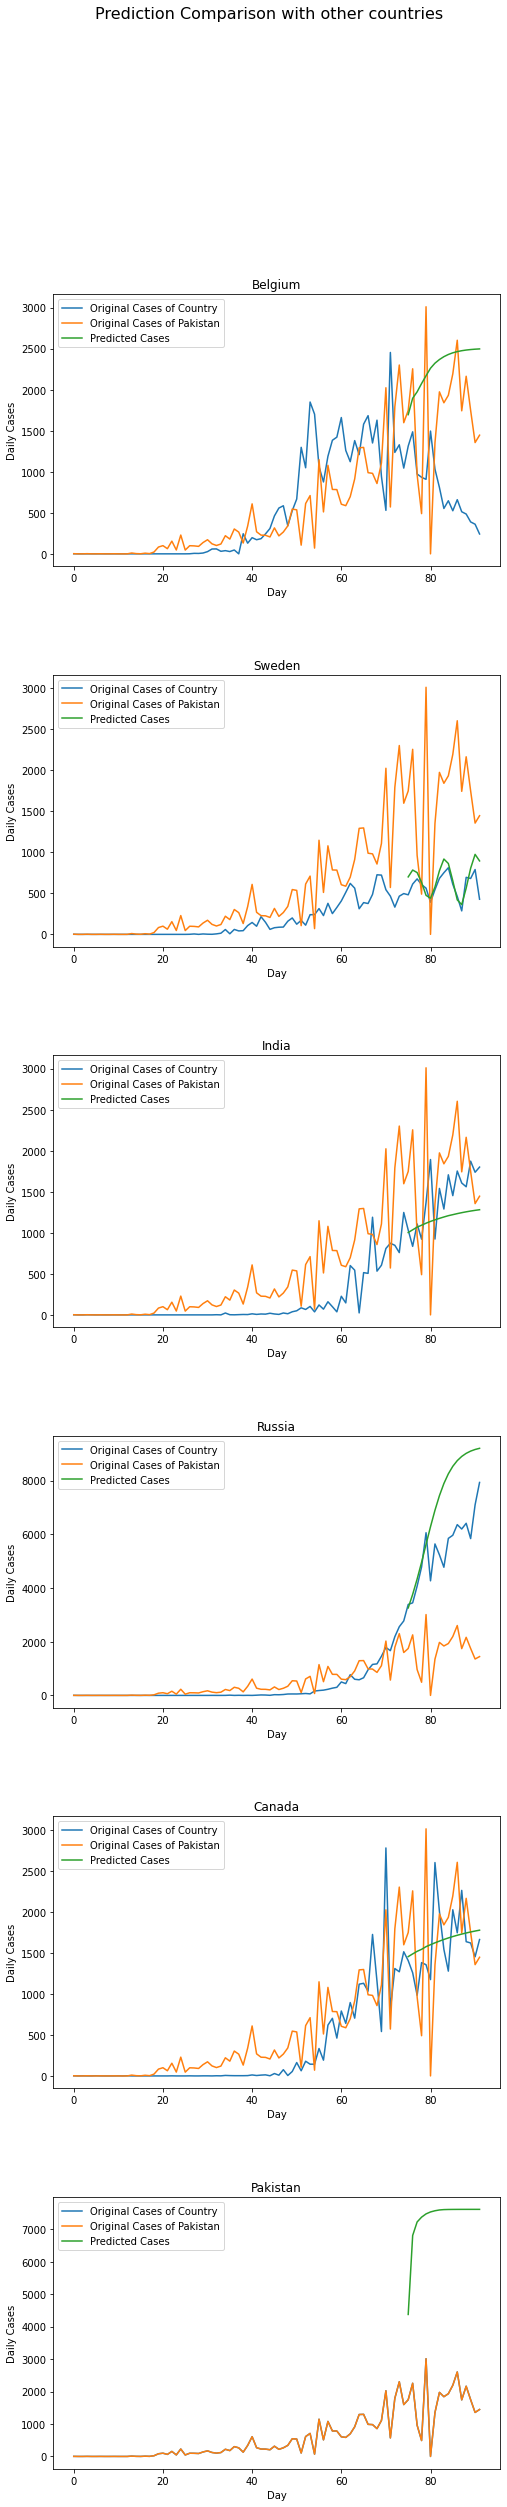

In [817]:
days = [x for x in range(92)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days,country_series[:len(days)], label = "Original Cases of Country")
    axs[i].plot(days,pak_series, label = "Original Cases of Pakistan")
    axs[i].plot(days[-17:],pred_trend[country], label = "Predicted Cases")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

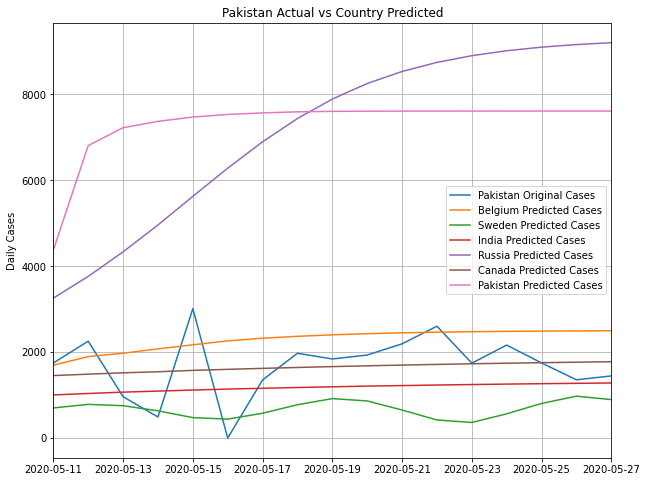

In [818]:
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-11",end="2020-05-27")
plt.plot(index,pak_series[-17:],label = "Pakistan Original Cases")
for country in pred_trend.keys():
  plt.plot(index,pred_trend[country], label = country+" Predicted Cases")
plt.legend();

## Prediction Comparison (27th May to 27th June)

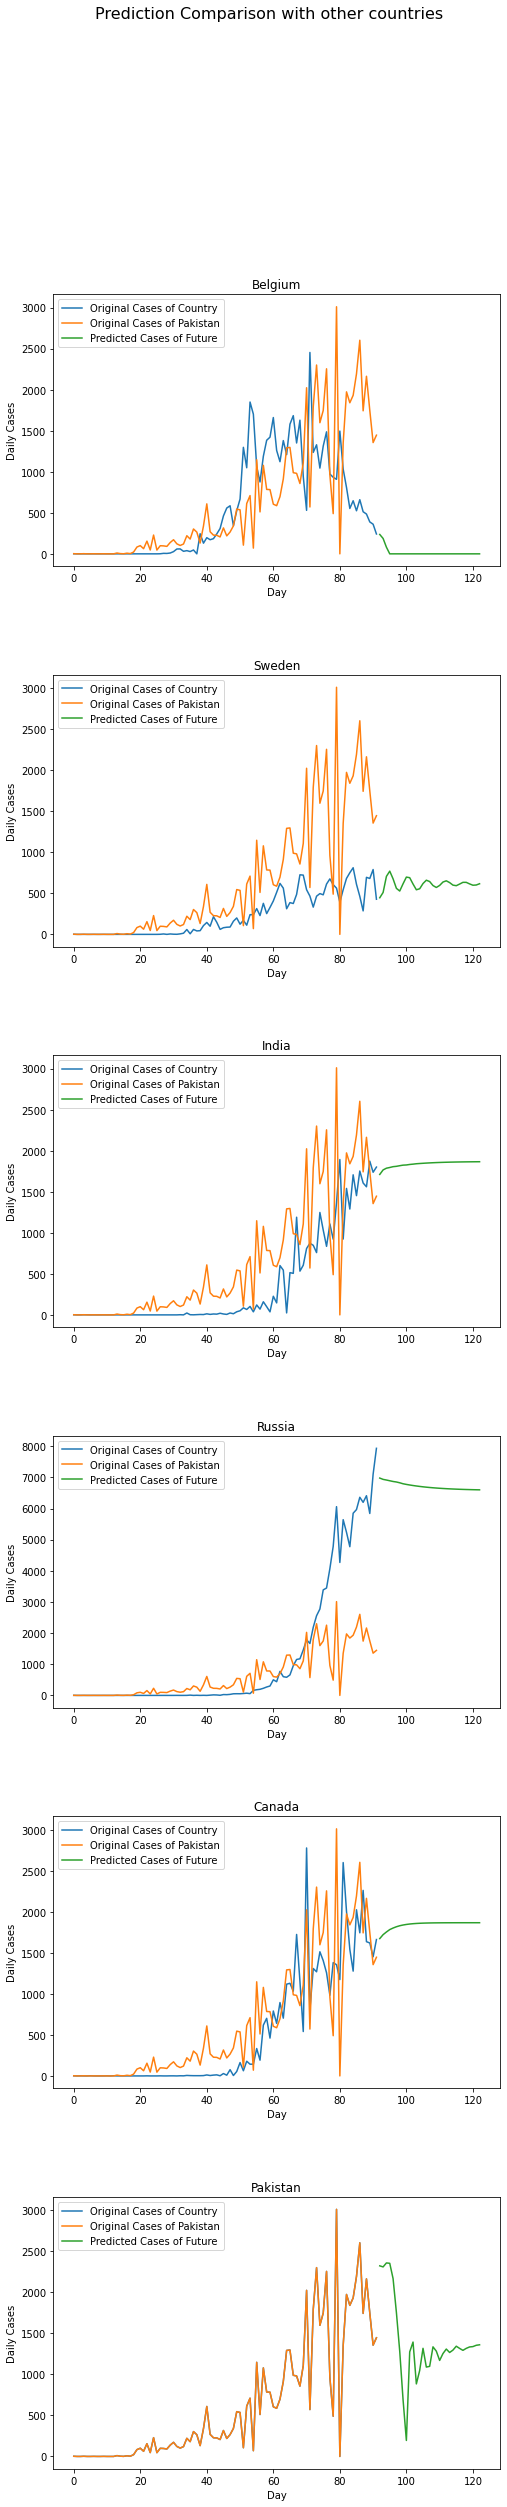

In [819]:
days = [x for x in range(92+31)]
pak_series = getDailyCaseSeries("Pakistan",dataset,'5/27/20')
fig,axs = plt.subplots(6,1,figsize=(8,40))
plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
fig.suptitle('Prediction Comparison with other countries', fontsize=16)
i = 0
for country in pred_trend.keys():
    country_series = getDailyCaseSeries(country,dataset,'5/27/20')
    axs[i].plot(days[:92],country_series[:92], label = "Original Cases of Country")
    axs[i].plot(days[:92],pak_series, label = "Original Cases of Pakistan")
    axs[i].plot(days[92:],pred_trend_fut[country], label = "Predicted Cases of Future")
    axs[i].set_title(country)
    axs[i].legend(loc='upper left')
    i+=1
for ax in axs.flat:
    ax.set(xlabel='Day', ylabel='Daily Cases')

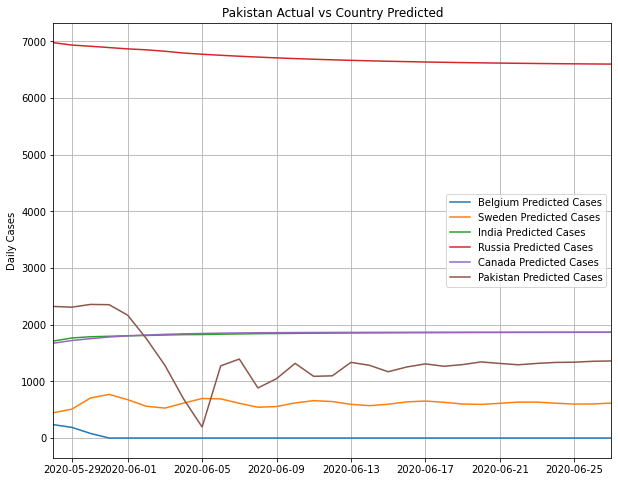

In [820]:
plt.figure(figsize=(10,8))
plt.title('Pakistan Actual vs Country Predicted')
plt.ylabel('Daily Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
index = pd.date_range(start="2020-05-28",end="2020-06-27")
# plt.plot(index,pak_series_test,label = "Pakistan Cases")
for country in pred_trend_fut.keys():
  plt.plot(index,pred_trend_fut[country], label = country+" Predicted Cases")
plt.legend();